# Portfolio allocation using random forest

## 1. Introduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno  # missingno库提供了一个很好的可视化缺失数据的方式
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## 2. Research Method

In [2]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3.1 Data Processing

## Financial Data

In [3]:
# Load the CSV file to examine its content
fin_data = pd.read_csv('2014-2024 Buffet Portfolio - financial ratios.csv')
fin_data.head()
fin_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gvkey            3602 non-null   int64  
 1   permno           3602 non-null   int64  
 2   adate            3599 non-null   object 
 3   qdate            3602 non-null   object 
 4   public_date      3602 non-null   object 
 5   CAPEI            3540 non-null   float64
 6   bm               3344 non-null   float64
 7   evm              3599 non-null   float64
 8   pe_op_basic      3583 non-null   float64
 9   pe_op_dil        3583 non-null   float64
 10  pe_exi           3583 non-null   float64
 11  pe_inc           3583 non-null   float64
 12  ps               3599 non-null   float64
 13  pcf              3584 non-null   float64
 14  dpr              3290 non-null   float64
 15  npm              3599 non-null   float64
 16  opmbd            3599 non-null   float64
 17  opmad         

In [4]:
# Converting 'public_date' into datetime type
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])

# Dropping unnecessary columns
columns_to_drop = ['gvkey', 'permno', 'adate', 'qdate', 'cusip']
fin_data = fin_data.drop(columns=columns_to_drop)

# Displaying the first few rows of the cleaned data
fin_data.head()

,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,...,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER
0,2014-01-31,19.421,0.224,15.807,18.183,18.539,19.596,19.596,3.533,15.880,...,1.459,121.125,0.0,0.07,0.0,-0.020,4.461,19.882,2.96%,KO
1,2014-02-28,18.781,0.216,16.794,18.454,18.818,20.105,20.105,3.592,15.965,...,1.412,13.414,0.0,0.07,0.0,-0.022,4.280,NaN,2.93%,KO
2,2014-03-31,19.007,0.216,16.794,18.676,19.044,20.347,20.347,3.635,16.157,...,1.412,13.414,0.0,0.07,0.0,-0.022,4.331,NaN,3.16%,KO
3,2014-04-30,20.005,0.216,16.794,19.705,20.094,21.468,21.468,3.826,17.006,...,1.412,13.414,0.0,0.07,0.0,-0.022,4.559,NaN,2.99%,KO
4,2014-05-31,20.253,0.229,16.135,19.763,20.252,21.877,21.877,3.876,16.155,...,1.426,59.367,0.0,0.07,0.0,-0.030,4.621,NaN,2.98%,KO


In [5]:
fin_data.describe()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
count,3540.000000,3344.000000,3599.000000,3583.000000,3583.000000,3583.000000,3583.000000,3599.000000,3584.000000,3290.000000,...,3475.000000,3596.00000,3333.000000,1819.000000,3599.000000,3599.000000,3599.000000,3584.000000,3344.000000,2392.000000
mean,32.893516,0.585623,11.982805,14.247707,14.313429,17.392147,18.810393,3.985088,14.299744,0.408672,...,9.187782,1.20293,3.225070,15.781792,0.014732,0.018644,0.062469,-0.040348,5.954551,1.650738
std,140.826711,0.480657,136.213259,54.442736,54.700132,62.646134,61.655598,7.587980,37.291236,2.173357,...,12.649030,1.85371,9.227582,50.059472,0.047221,0.026105,0.110894,0.052159,10.137153,5.297652
min,-2615.300000,0.003000,-4544.900000,-714.520000,-714.520000,-942.310000,-868.340000,0.139000,-614.440000,0.000000,...,0.001000,0.11300,0.120000,-172.250000,0.000000,0.000000,0.000000,-0.267000,0.281000,-54.053000
25%,12.721250,0.186000,9.938000,10.206500,10.334500,9.739500,9.571000,1.217500,5.955250,0.000000,...,1.914000,0.37000,0.671000,3.269000,0.000000,0.000000,0.000000,-0.067000,1.111000,0.228000
50%,21.916500,0.487000,13.438000,16.865000,17.238000,17.837000,17.690000,1.915000,11.212500,0.199000,...,4.070000,0.71700,1.379000,6.188000,0.000000,0.006000,0.000000,-0.033500,2.088000,0.711500
75%,34.628250,0.872000,18.146000,26.874000,27.526000,29.549500,30.018000,3.958500,20.463000,0.352000,...,11.589000,1.18000,2.493000,13.542000,0.004000,0.031000,0.126000,-0.011000,5.411250,1.546000
max,1447.000000,2.968000,983.733000,478.000000,490.500000,480.000000,516.316000,126.556000,400.801000,66.000000,...,77.108000,31.21200,152.413000,977.032000,0.465000,0.129000,0.423000,0.152000,64.657000,63.498000


In [6]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   public_date      3602 non-null   datetime64[ns]
 1   CAPEI            3540 non-null   float64       
 2   bm               3344 non-null   float64       
 3   evm              3599 non-null   float64       
 4   pe_op_basic      3583 non-null   float64       
 5   pe_op_dil        3583 non-null   float64       
 6   pe_exi           3583 non-null   float64       
 7   pe_inc           3583 non-null   float64       
 8   ps               3599 non-null   float64       
 9   pcf              3584 non-null   float64       
 10  dpr              3290 non-null   float64       
 11  npm              3599 non-null   float64       
 12  opmbd            3599 non-null   float64       
 13  opmad            3599 non-null   float64       
 14  gpm              3599 non-null   float64

In [7]:
fin_data.isnull().sum() 

public_date        0
CAPEI             62
bm               258
evm                3
pe_op_basic       19
                ... 
accrual           18
ptb              258
PEG_trailing    1210
divyield        1169
TICKER            12
Length: 71, dtype: int64

In [8]:
# Identify columns that may contain percentage signs or non-numeric values
for col in fin_data.columns:
    if fin_data[col].dtype == 'object':
        # Check if there's a percentage sign and convert
        try:
            fin_data[col] = fin_data[col].str.replace('%', '').astype(float) / 100
        except Exception as e:
            print(f"Issue with column {col}: {e}")

Issue with column TICKER: could not convert string to float: 'KO'


In [9]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   public_date      3602 non-null   datetime64[ns]
 1   CAPEI            3540 non-null   float64       
 2   bm               3344 non-null   float64       
 3   evm              3599 non-null   float64       
 4   pe_op_basic      3583 non-null   float64       
 5   pe_op_dil        3583 non-null   float64       
 6   pe_exi           3583 non-null   float64       
 7   pe_inc           3583 non-null   float64       
 8   ps               3599 non-null   float64       
 9   pcf              3584 non-null   float64       
 10  dpr              3290 non-null   float64       
 11  npm              3599 non-null   float64       
 12  opmbd            3599 non-null   float64       
 13  opmad            3599 non-null   float64       
 14  gpm              3599 non-null   float64

## Missing Data

CAPEI             62
bm               258
evm                3
pe_op_basic       19
pe_op_dil         19
                ... 
accrual           18
ptb              258
PEG_trailing    1210
divyield        1169
TICKER            12
Length: 70, dtype: int64
缺失值比例：
sale_nwc           0.495003
cash_conversion    0.492782
PEG_trailing       0.335924
divyield           0.324542
invt_act           0.310105
                     ...   
gpm                0.000833
cfm                0.000833
GProf              0.000833
cash_lt            0.000833
de_ratio           0.000833
Length: 70, dtype: float64


<Figure size 600x500 with 0 Axes>

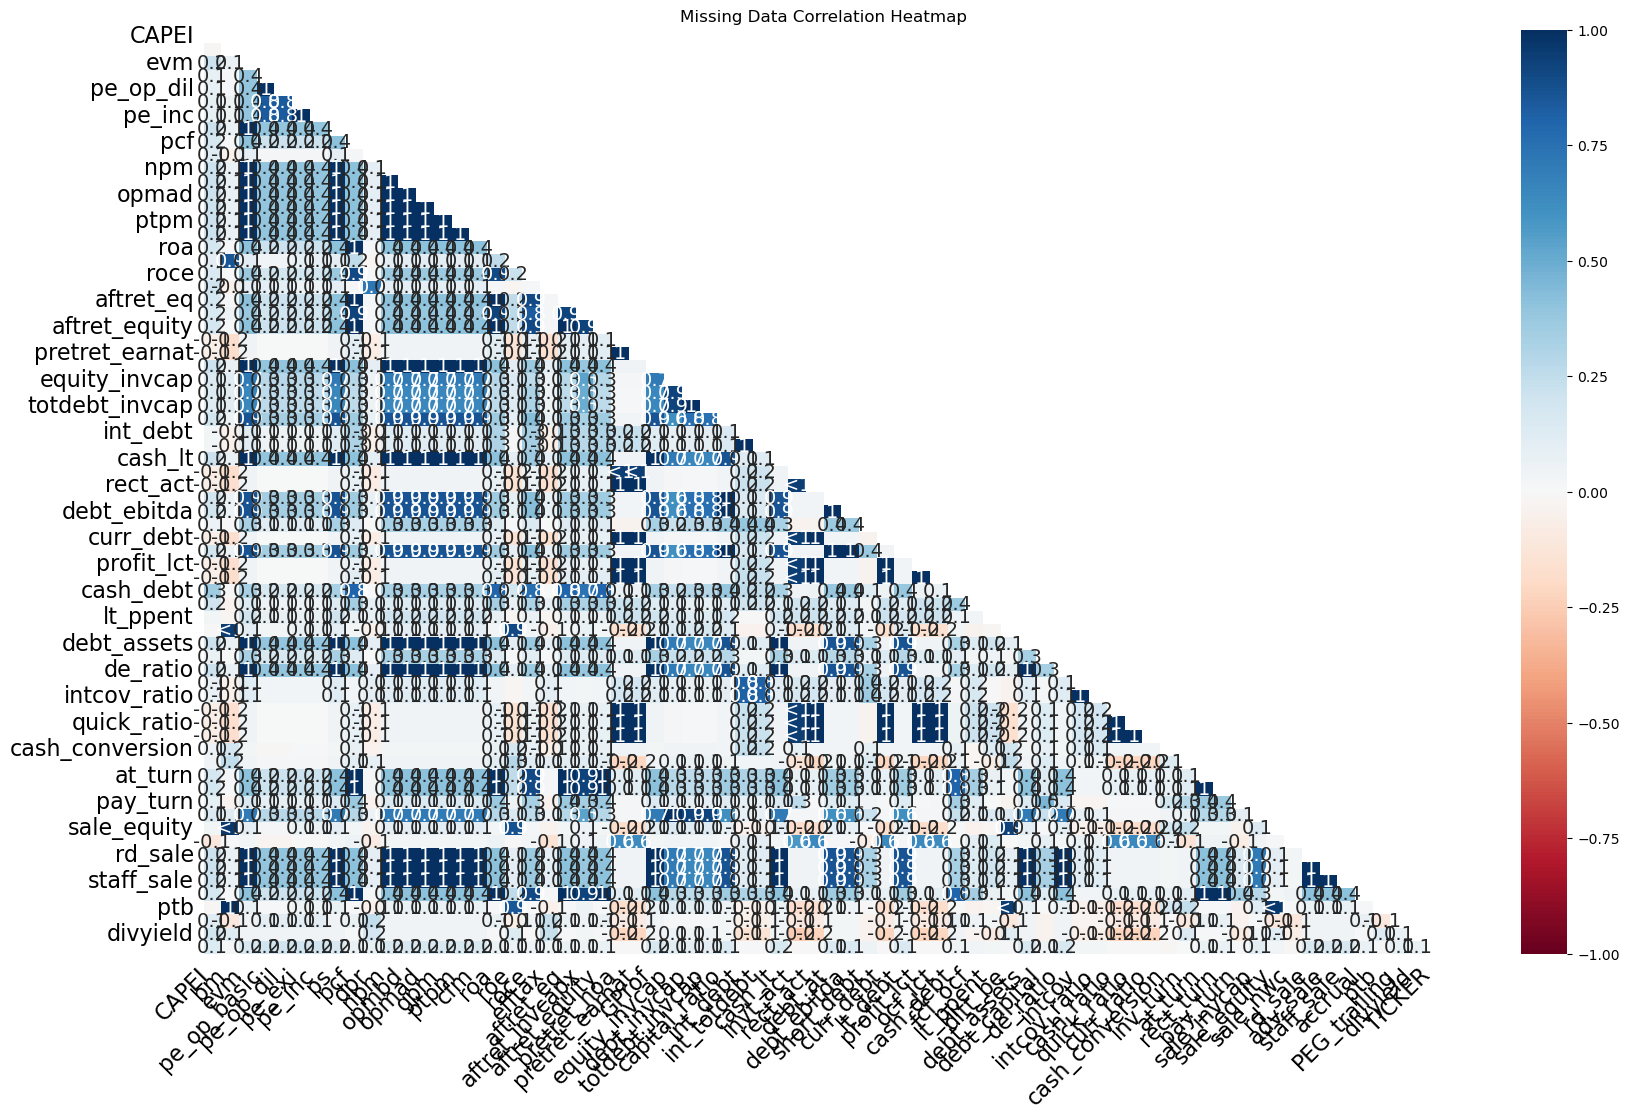

In [10]:
# Check the missing in the data
# 检查数据中的缺失情况
missing_values = fin_data.isnull().sum()
print(missing_values[missing_values > 0])

# 计算每个变量的缺失值比例
missing_ratios = fin_data.isnull().mean().sort_values(ascending=False)
print("缺失值比例：")
print(missing_ratios[missing_ratios > 0])  # 只显示有缺失值的变量

# 可视化缺失数据的相关性
plt.figure(figsize=(6, 5))
msno.heatmap(fin_data)
plt.title('Missing Data Correlation Heatmap')
plt.show()


In [11]:
# fin_data = fin_data.fillna(method = 'ffill', limit = 20).fillna(method = 'bfill', limit = 20)

# fin_data.iloc[0] = fin_data.iloc[0].fillna(fin_data.iloc[0:5].mean(numeric_only=True))
# fin_data.iloc[-1] = fin_data.iloc[-1].fillna(fin_data.iloc[-5:].mean(numeric_only=True))

# #update every quater
# fin_data['bm'] = fin_data.groupby(fin_data.index.to_period('Q'))['bm'].fillna(method='ffill')

# #对于波动较大的指标，可以考虑使用滚动平均填充
# fin_data['PEG_trailing'] = fin_data['PEG_trailing'].fillna(fin_data['PEG_trailing'].rolling(window=30, min_periods=1).mean())

# #股息收益率缺失可能意味着公司不派息。
# fin_data['divyield'] = fin_data['divyield'].fillna(0)

# #对于某些连续的财务指标，可以尝试插值
# fin_data['CAPEI'] = fin_data['CAPEI'].interpolate(method='time')

# #对于复杂的缺失模式，可以考虑使用多重插补方法，如MICE（Multiple Imputation by Chained Equations）
# imputer = IterativeImputer(max_iter=10, random_state=0)
# fin_data_imputed = pd.DataFrame(imputer.fit_transform(fin_data), columns=fin_data.columns)

In [12]:
# 确保数据按日期排序
fin_data = fin_data.sort_index()

# 1. 高缺失率组处理
high_missing_cols = ['cash_conversion', 'sale_nwc']

for col in high_missing_cols:
    # 使用时间窗口的中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].rolling(window=30, min_periods=1, center=True).median())
    # 对于开始和结束的缺失值，使用全局中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].median())

# divyield 假设缺失值为0（公司不派息）
fin_data['divyield'] = fin_data['divyield'].fillna(0)

# 2. 中等缺失率组处理
med_missing_cols = ['invt_act', 'inv_turn', 'curr_ratio', 'quick_ratio', 'cash_ratio', 
                    'ocf_lct', 'profit_lct', 'curr_debt', 'pretret_earnat', 'pretret_noa', 'rect_act',
                    'PEG_trailing']

for col in med_missing_cols:
    # 先进行前向填充
    fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
    # 然后使用时间窗口的中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].rolling(window=30, min_periods=1, center=True).median())
    # 对于仍然存在的缺失值，使用全局中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].median())

# 3. 低缺失率组处理
low_missing_cols = ['sale_equity', 'int_totdebt', 'int_debt', 'intcov_ratio', 'ptb', 'bm']

for col in low_missing_cols:
    # 使用前向填充，然后后向填充
    fin_data[col] = fin_data[col].fillna(method='ffill').fillna(method='bfill')

# 4. 极低缺失率组处理
very_low_missing_cols = ['debt_ebitda', 'pe_inc', 'pe_op_dil', 'pe_op_basic', 'pe_exi']

for col in very_low_missing_cols:
    # 使用简单的线性插值
    fin_data[col] = fin_data[col].interpolate()


print("Data preparation completed.")

Data preparation completed.


In [13]:
# 5. 对剩余的数值型变量使用 MICE 方法
numeric_columns = fin_data.select_dtypes(include=[np.number]).columns.tolist()

mice_imputer = IterativeImputer(max_iter=20, random_state=0)
fin_data_mice = pd.DataFrame(mice_imputer.fit_transform(fin_data[numeric_columns]), 
                             columns=numeric_columns, index=fin_data.index)
fin_data.update(fin_data_mice)

# 6. 处理任何剩余的缺失值
non_numeric_columns = fin_data.select_dtypes(exclude=[np.number]).columns.tolist()
mode_imputer = SimpleImputer(strategy='most_frequent')
fin_data[non_numeric_columns] = mode_imputer.fit_transform(fin_data[non_numeric_columns])

# 7. 检查是否还有剩余的缺失值
remaining_missing = fin_data.isnull().sum()
print("Remaining missing values:\n", remaining_missing[remaining_missing > 0])

print("Data preparation completed.")

Remaining missing values:
 Series([], dtype: int64)
Data preparation completed.


## Stock Data

In [14]:
# Load the CSV file to examine its content
sto_data = pd.read_csv('2014-2024 Buffet Portfolio - stock.csv')
sto_data.head()
sto_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 63 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERMNO    89589 non-null  int64  
 1   date      89589 non-null  object 
 2   NAMEENDT  127 non-null    object 
 3   SHRCD     89589 non-null  int64  
 4   EXCHCD    89589 non-null  int64  
 5   SICCD     89589 non-null  object 
 6   NCUSIP    89589 non-null  object 
 7   TICKER    89589 non-null  object 
 8   COMNAM    89589 non-null  object 
 9   SHRCLS    24210 non-null  object 
 10  TSYMBOL   89589 non-null  object 
 11  NAICS     89563 non-null  float64
 12  PRIMEXCH  89589 non-null  object 
 13  TRDSTAT   89589 non-null  object 
 14  SECSTAT   89589 non-null  object 
 15  PERMCO    89589 non-null  int64  
 16  ISSUNO    89589 non-null  int64  
 17  HEXCD     89589 non-null  int64  
 18  HSICCD    89589 non-null  int64  
 19  CUSIP     89589 non-null  object 
 20  DCLRDT    931 non-null    ob

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/2704999772.py:2: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  sto_data = pd.read_csv('2014-2024 Buffet Portfolio - stock.csv')


In [15]:
sto_data_selected = sto_data.copy()

In [16]:
# Converting 'public_date' into datetime type
sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])

In [17]:
# 步骤1: 处理因变量(投资回报率)
def clean_ret(ret):
    if isinstance(ret, str):
        # 处理特殊情况，如'C'或'B'
        if ret in ['C', 'B']:
            return np.nan
        # 移除百分号并转换为浮点数
        return float(ret.strip('%')) / 100
    return ret

# 将'RET'列转换为数值类型
sto_data_selected['RET'] = sto_data_selected['RET'].apply(clean_ret)

In [18]:
# 步骤3: 选择相关特征
relevant_features = ['date', 'TICKER', 'COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 
                     'PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 
                     'vwretd', 'ewretd', 'sprtrn']
sto_data_selected = sto_data_selected[relevant_features]

In [19]:
sto_data_selected.describe()

,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,BIDLO,ASKHI,OPENPRC,vwretd,ewretd,sprtrn
count,89589.000000,89589.000000,89583.000000,8.958300e+04,89570.000000,8.958300e+04,89583.000000,89583.000000,89583.000000,89589.000000,89589.000000,89589.000000
mean,15.129893,1.757973,227.601511,1.079223e+07,0.000257,1.314680e+06,224.950986,230.144809,227.541278,0.000449,0.000343,0.000439
std,14.497378,1.053536,635.967039,2.389194e+07,0.012422,2.443694e+06,627.836061,643.910272,635.758014,0.011025,0.010709,0.011170
min,11.000000,1.000000,3.065000,4.099000e+03,-0.283530,3.179000e+03,2.980000,3.110000,3.050000,-0.118168,-0.107631,-0.119841
25%,11.000000,1.000000,37.470000,9.286940e+05,-0.000243,1.845000e+05,36.990000,37.950000,37.475000,-0.003923,-0.004576,-0.003812
50%,11.000000,1.000000,76.680000,2.602606e+06,0.000011,4.387400e+05,75.880300,77.420000,76.660000,0.000668,0.000709,0.000597
75%,11.000000,3.000000,163.575005,7.792302e+06,0.000370,1.045085e+06,161.955000,165.174995,163.519995,0.005631,0.005748,0.005690
max,73.000000,4.000000,7024.819820,5.072443e+08,0.422587,1.710254e+07,6997.910160,7075.000000,7028.500000,0.091556,0.082175,0.093828


In [20]:
sto_data_selected.columns

Index(['date', 'TICKER', 'COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL',
       'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd',
       'sprtrn'],
      dtype='object')

In [21]:
sto_data_selected.isnull().sum() 

date        0
TICKER      0
COMNAM      0
SHRCD       0
EXCHCD      0
SICCD       0
PRC         6
VOL         6
RET        19
SHROUT      6
BIDLO       6
ASKHI       6
OPENPRC     6
vwretd      0
ewretd      0
sprtrn      0
dtype: int64

In [22]:
sto_data_selected.head()

,date,TICKER,COMNAM,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SHROUT,BIDLO,ASKHI,OPENPRC,vwretd,ewretd,sprtrn
0,2014-01-02,KO,COCA COLA CO,11,1,2086,40.66,12720200.0,-0.000157,4415923.0,40.51,41.2250,41.12,-0.008757,-0.004051,-0.008862
1,2014-01-03,KO,COCA COLA CO,11,1,2086,40.46,10403800.0,-0.000049,4415923.0,40.35,40.7300,40.68,0.000491,0.004096,-0.000333
2,2014-01-06,KO,COCA COLA CO,11,1,2086,40.27,11041200.0,-0.000047,4415923.0,40.16,40.5926,40.48,-0.003340,-0.001676,-0.002512
3,2014-01-07,KO,COCA COLA CO,11,1,2086,40.39,11879600.0,0.000030,4415923.0,40.29,40.7208,40.48,0.006090,0.006892,0.006082
4,2014-01-08,KO,COCA COLA CO,11,1,2086,39.94,15357500.0,-0.000111,4415923.0,39.83,40.4400,40.44,0.000155,0.000835,-0.000212


In [23]:
# 3. TICKER (object) - 保持为字符串，可能需要进行标签编码
sto_data_selected['TICKER'] = sto_data_selected['TICKER'].astype('category')

# 5. SHRCD (int64) - 转换为类别型
sto_data_selected['SHRCD'] = sto_data_selected['SHRCD'].astype('category')

# 6. EXCHCD (int64) - 转换为类别型
sto_data_selected['EXCHCD'] = sto_data_selected['EXCHCD'].astype('category')

# 7. SICCD (object) - 转换为类别型
sto_data_selected['SICCD'] = sto_data_selected['SICCD'].astype('category')

In [24]:
# 定义一个函数来安全地应用LabelEncoder
def safe_label_encode(series):
    # 将所有值转换为字符串
    series = series.astype(str)
    le = LabelEncoder()
    return pd.Series(le.fit_transform(series), index=series.index)

# 对于可能需要进行机器学习的类别型变量，我们使用安全的编码方法
for col in ['TICKER', 'SHRCD', 'EXCHCD', 'SICCD']:
    # 首先，检查列中是否存在缺失值
    if sto_data_selected[col].isnull().any():
        # 如果存在缺失值，先填充它们
        sto_data_selected[col] = sto_data_selected[col].fillna('Unknown')
    
    # 然后应用安全的标签编码
    sto_data_selected[col + '_encoded'] = safe_label_encode(sto_data_selected[col])
    
    # 将原始列转换为类别类型
    sto_data_selected[col] = sto_data_selected[col].astype('category')

# 显示处理后的数据类型
print(sto_data_selected.dtypes)

date              datetime64[ns]
TICKER                  category
COMNAM                    object
SHRCD                   category
EXCHCD                  category
SICCD                   category
PRC                      float64
VOL                      float64
RET                      float64
SHROUT                   float64
BIDLO                    float64
ASKHI                    float64
OPENPRC                  float64
vwretd                   float64
ewretd                   float64
sprtrn                   float64
TICKER_encoded             int64
SHRCD_encoded              int64
EXCHCD_encoded             int64
SICCD_encoded              int64
dtype: object


In [25]:
# # Identify columns that may contain percentage signs or non-numeric values
# for col in fin_data.columns:
#     if fin_data[col].dtype == 'object':
#         # Check if there's a percentage sign and convert
#         try:
#             fin_data[col] = fin_data[col].str.replace('%', '').astype(float) / 100
#         except Exception as e:
#             print(f"Issue with column {col}: {e}")

In [26]:
sto_data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            89589 non-null  datetime64[ns]
 1   TICKER          89589 non-null  category      
 2   COMNAM          89589 non-null  object        
 3   SHRCD           89589 non-null  category      
 4   EXCHCD          89589 non-null  category      
 5   SICCD           89589 non-null  category      
 6   PRC             89583 non-null  float64       
 7   VOL             89583 non-null  float64       
 8   RET             89570 non-null  float64       
 9   SHROUT          89583 non-null  float64       
 10  BIDLO           89583 non-null  float64       
 11  ASKHI           89583 non-null  float64       
 12  OPENPRC         89583 non-null  float64       
 13  vwretd          89589 non-null  float64       
 14  ewretd          89589 non-null  float64       
 15  sp

## Missing Data

PRC         6
VOL         6
RET        19
SHROUT      6
BIDLO       6
ASKHI       6
OPENPRC     6
dtype: int64
缺失值比例：
RET        0.000212
BIDLO      0.000067
PRC        0.000067
VOL        0.000067
SHROUT     0.000067
ASKHI      0.000067
OPENPRC    0.000067
dtype: float64


<Figure size 600x500 with 0 Axes>

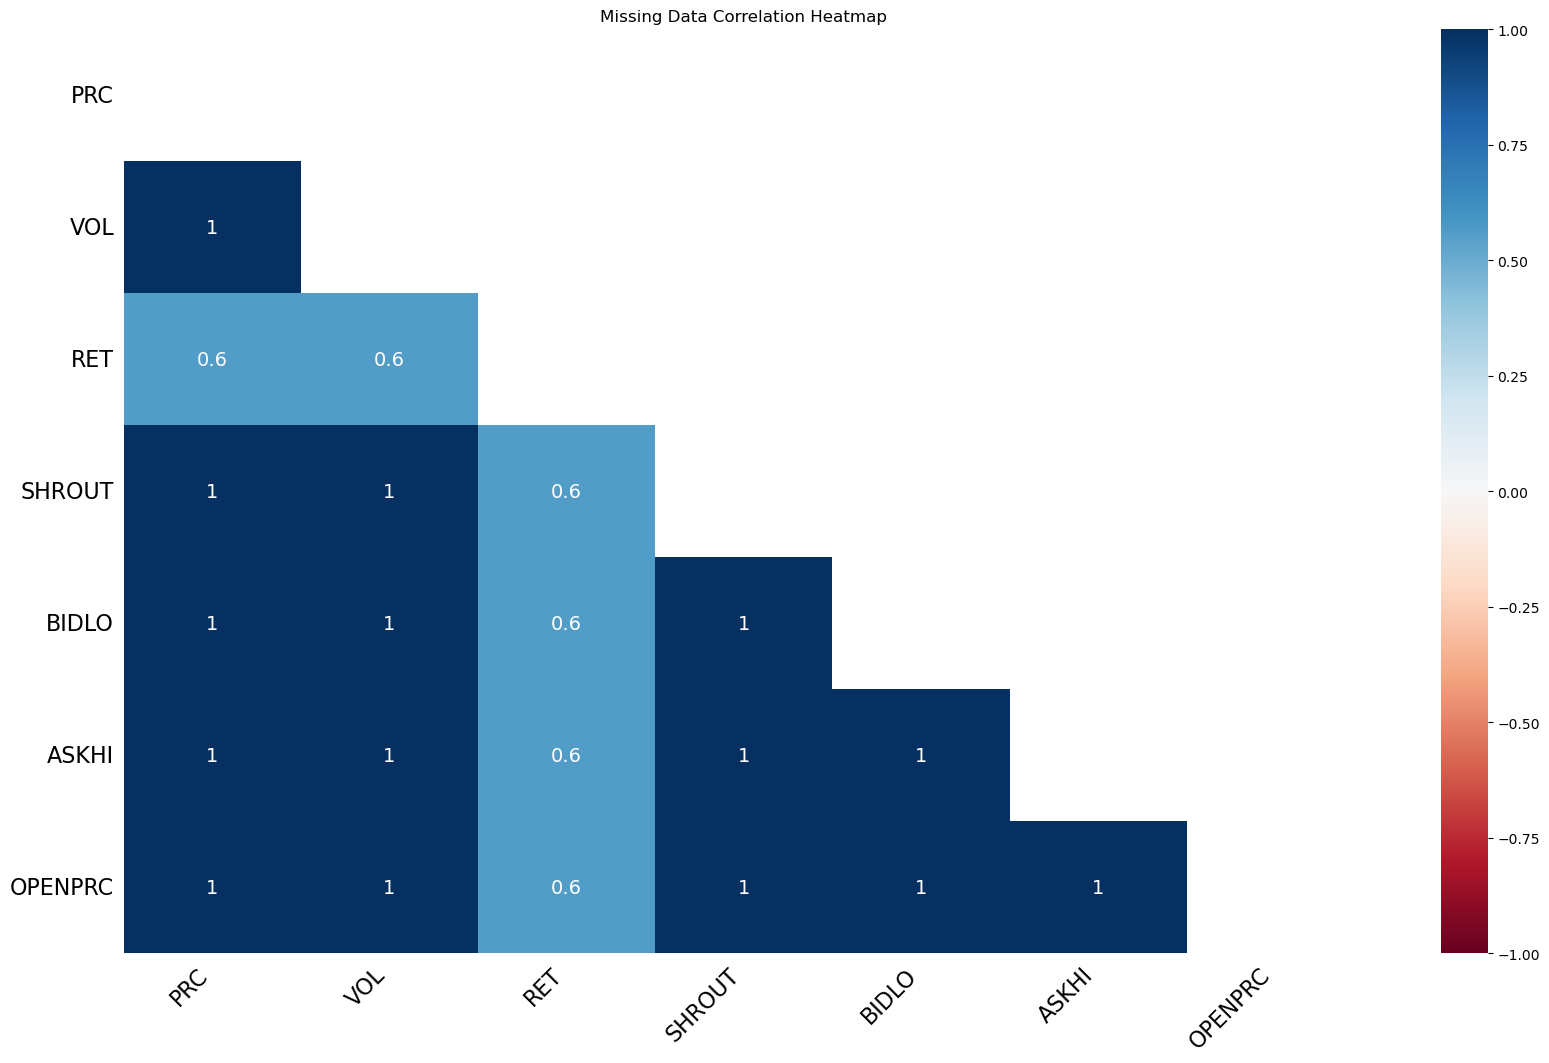

In [27]:
# Check the missing in the data
# 检查数据中的缺失情况
missing_values = sto_data_selected.isnull().sum()
print(missing_values[missing_values > 0])

# 计算每个变量的缺失值比例
missing_ratios = sto_data_selected.isnull().mean().sort_values(ascending=False)
print("缺失值比例：")
print(missing_ratios[missing_ratios > 0])  # 只显示有缺失值的变量

# 可视化缺失数据的相关性
plt.figure(figsize=(6, 5))
msno.heatmap(sto_data_selected)
plt.title('Missing Data Correlation Heatmap')
plt.show()


In [28]:
# 确保数据按日期排序
sto_data_selected = sto_data_selected.sort_values('date')

# 对价格类数据使用前向填充
price_columns = ['PRC', 'BIDLO', 'ASKHI', 'OPENPRC']
sto_data_selected[price_columns] = sto_data_selected.groupby('TICKER')[price_columns].fillna(method='ffill')

# 对交易量和流通股数使用前向填充
sto_data_selected[['VOL', 'SHROUT']] = sto_data_selected.groupby('TICKER')[['VOL', 'SHROUT']].fillna(method='ffill')



# 重新计算市值
sto_data_selected['market_cap'] = sto_data_selected['PRC'].abs() * sto_data_selected['SHROUT']

# 检查剩余的缺失值
missing_after = sto_data_selected[['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']].isnull().sum()
print("处理后的缺失值：")
print(missing_after)


处理后的缺失值：
PRC            0
VOL            0
RET           19
SHROUT         0
BIDLO          0
ASKHI          0
OPENPRC        0
market_cap     0
dtype: int64


In [29]:
sto_data_selected['RET'] = sto_data['RET'] 


In [30]:
# 处理回报率 (RET)
# 方法1：如果可能，基于价格重新计算
sto_data_selected['RET_calc'] = sto_data_selected.groupby('TICKER',group_keys=False)['PRC'].pct_change()

# 方法2：对原始 RET 使用线性插值
sto_data_selected['RET_interp'] = sto_data_selected.groupby('TICKER',group_keys=False)['RET'].apply(lambda x: x.interpolate(method='linear'))

# 合并两种方法的结果
sto_data_selected['RET'] = sto_data_selected['RET'].fillna(sto_data_selected['RET_calc'])
sto_data_selected['RET'] = sto_data_selected['RET'].fillna(sto_data_selected['RET_interp'])


In [31]:
missing_after = sto_data_selected[['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']].isnull().sum()
print("处理后的缺失值：")
print(missing_after)

处理后的缺失值：
PRC           0
VOL           0
RET           0
SHROUT        0
BIDLO         0
ASKHI         0
OPENPRC       0
market_cap    0
dtype: int64


In [32]:
# # 如果仍有缺失值，可能是因为某些股票在数据集开始时就有缺失值，我们可以使用后向填充来处理这种情况
# if missing_after.sum() > 0:
#     columns_to_fill = ['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']
#     sto_data_selected[columns_to_fill] = sto_data_selected.groupby('PERMNO')[columns_to_fill].fillna(method='bfill')

#     # 再次检查缺失值
#     missing_final = sto_data_selected[columns_to_fill].isnull().sum()
#     print("\n最终处理后的缺失值：")
#     print(missing_final)

# # 如果仍有缺失值，可能需要考虑删除这些行或使用更复杂的填充方法
# if missing_final.sum() > 0:
#     print("\n警告：仍有缺失值存在。可能需要进一步处理或考虑删除这些行。")

## Macroeconomic Index

In [33]:
dfy = pd.read_csv('DFY (Default Yield Spread)- 2014 - 2024.csv')
tbl = pd.read_csv('TBL (Treasury Bill Rate) - 2014 - 2024.csv')
tms = pd.read_csv('TMS (Term Spread) - 2014 - 2024.csv')

In [34]:
dfy.info()
tbl.info()
tms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    2740 non-null   object
 1   BAA10Y  2740 non-null   object
dtypes: object(2)
memory usage: 42.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    126 non-null    object 
 1   TB3MS   126 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742 entries, 0 to 2741
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    2742 non-null   object
 1   T10Y2Y  2742 non-null   object
dtypes: object(2)
memory usage: 43.0+ KB


In [35]:
# 检查每个 DataFrame 的基本信息
print("tbl shape:", tbl.shape)
print("tms shape:", tms.shape)
print("dfy shape:", dfy.shape)

print("\ntbl head:")
print(tbl.head())
print("\ntms head:")
print(tms.head())
print("\ndfy head:")
print(dfy.head())

# 检查日期范围
print("\nDate ranges:")
print("tbl:", tbl.index.min(), "to", tbl.index.max())
print("tms:", tms.index.min(), "to", tms.index.max())
print("dfy:", dfy.index.min(), "to", dfy.index.max())



tbl shape: (126, 2)
tms shape: (2742, 2)
dfy shape: (2740, 2)

tbl head:
         DATE  TB3MS
0  2014-01-01   0.04
1  2014-02-01   0.05
2  2014-03-01   0.05
3  2014-04-01   0.03
4  2014-05-01   0.03

tms head:
         DATE T10Y2Y
0  2014-01-02   2.61
1  2014-01-03   2.60
2  2014-01-06   2.58
3  2014-01-07   2.56
4  2014-01-08   2.58

dfy head:
         DATE BAA10Y
0  2014-01-02   2.34
1  2014-01-03   2.34
2  2014-01-06   2.32
3  2014-01-07   2.32
4  2014-01-08   2.31

Date ranges:
tbl: 0 to 125
tms: 0 to 2741
dfy: 0 to 2739


In [36]:
tbl.index = pd.to_datetime(tbl.DATE)
tbl.drop(columns='DATE', inplace=True)  # 移除原始的 DATE 列

tms.index = pd.to_datetime(tms.DATE)
tms.drop(columns='DATE', inplace=True)  # 移除原始的 DATE 列

dfy.index = pd.to_datetime(dfy.DATE)
dfy.drop(columns='DATE', inplace=True)  # 移除原始的 DATE 列


In [37]:
print("\ntbl head:")
print(tbl.head())
print("\ntms head:")
print(tms.head())
print("\ndfy head:")
print(dfy.head())

# 检查日期范围
print("\nDate ranges:")
print("tbl:", tbl.index.min(), "to", tbl.index.max())
print("tms:", tms.index.min(), "to", tms.index.max())
print("dfy:", dfy.index.min(), "to", dfy.index.max())


tbl head:
            TB3MS
DATE             
2014-01-01   0.04
2014-02-01   0.05
2014-03-01   0.05
2014-04-01   0.03
2014-05-01   0.03

tms head:
           T10Y2Y
DATE             
2014-01-02   2.61
2014-01-03   2.60
2014-01-06   2.58
2014-01-07   2.56
2014-01-08   2.58

dfy head:
           BAA10Y
DATE             
2014-01-02   2.34
2014-01-03   2.34
2014-01-06   2.32
2014-01-07   2.32
2014-01-08   2.31

Date ranges:
tbl: 2014-01-01 00:00:00 to 2024-06-01 00:00:00
tms: 2014-01-02 00:00:00 to 2024-07-05 00:00:00
dfy: 2014-01-02 00:00:00 to 2024-07-03 00:00:00


In [38]:
# 定义一个函数来安全地转换为浮点数
def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# 将所有列转换为float类型，同时处理无效值
tbl['TB3MS'] = tbl['TB3MS'].apply(safe_float)
tms['T10Y2Y'] = tms['T10Y2Y'].apply(safe_float)
dfy['BAA10Y'] = dfy['BAA10Y'].apply(safe_float)

# 检查转换后的数据
print("tbl head after conversion:")
print(tbl.head())
print("\ntms head after conversion:")
print(tms.head())
print("\ndfy head after conversion:")
print(dfy.head())

tbl head after conversion:
            TB3MS
DATE             
2014-01-01   0.04
2014-02-01   0.05
2014-03-01   0.05
2014-04-01   0.03
2014-05-01   0.03

tms head after conversion:
            T10Y2Y
DATE              
2014-01-02    2.61
2014-01-03    2.60
2014-01-06    2.58
2014-01-07    2.56
2014-01-08    2.58

dfy head after conversion:
            BAA10Y
DATE              
2014-01-02    2.34
2014-01-03    2.34
2014-01-06    2.32
2014-01-07    2.32
2014-01-08    2.31


In [39]:
# 对所有数据进行月度重采样
tbl_monthly = tbl.resample('M').last()  # 使用月末数据
tms_monthly = tms.resample('M').mean()  # 月平均
dfy_monthly = dfy.resample('M').mean()  # 月平均

# 合并数据
macro_data = tbl_monthly.join(tms_monthly, how='outer').join(dfy_monthly, how='outer')

# 用前向填充方法处理缺失值
macro_data = macro_data.ffill()

print("Merged and resampled data info:")
print(macro_data.info())

print("\nMerged and resampled data head:")
print(macro_data.head())

# 检查是否还有缺失值
print("\nMissing values:")
print(macro_data.isnull().sum())

Merged and resampled data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2014-01-31 to 2024-07-31
Freq: M
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TB3MS   127 non-null    float64
 1   T10Y2Y  127 non-null    float64
 2   BAA10Y  127 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB
None

Merged and resampled data head:
            TB3MS    T10Y2Y    BAA10Y
DATE                                 
2014-01-31   0.04  2.464286  2.334762
2014-02-28   0.05  2.382632  2.390000
2014-03-31   0.05  2.324286  2.340952
2014-04-30   0.03  2.288095  2.199048
2014-05-31   0.03  2.170000  2.203810

Missing values:
TB3MS     0
T10Y2Y    0
BAA10Y    0
dtype: int64


## Merge dataset

In [40]:
# fin_data = fin_data_temp

In [41]:
# 1. 设置日期索引
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])
fin_data.set_index('public_date', inplace=True)

sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])
sto_data_selected.set_index('date', inplace=True)

# 确保 econ 的索引是 DatetimeIndex
macro_data.index = pd.to_datetime(macro_data.index)

#已经是dataframe且为index了

In [42]:
# 检查每个 DataFrame 的基本信息
print("financial data shape:", fin_data.shape)
print("stock data shape:", sto_data_selected.shape)
print("macroeconomic data shape:", macro_data.shape)

print("\nfin head:")
print(fin_data.head())
print("\nstk head:")
print(sto_data_selected.head())
print("\necon head:")
print(macro_data.head())

# 检查日期范围
print("\nDate ranges:")
print("fin:", fin_data.index.min(), "to", fin_data.index.max())
print("stk:", sto_data_selected.index.min(), "to", sto_data_selected.index.max())
print("econ:", macro_data.index.min(), "to", macro_data.index.max())


financial data shape: (3602, 70)
stock data shape: (89589, 22)
macroeconomic data shape: (127, 3)

fin head:
              CAPEI     bm     evm  pe_op_basic  pe_op_dil  pe_exi  pe_inc  \
public_date                                                                  
2014-01-31   19.421  0.224  15.807       18.183     18.539  19.596  19.596   
2014-02-28   18.781  0.216  16.794       18.454     18.818  20.105  20.105   
2014-03-31   19.007  0.216  16.794       18.676     19.044  20.347  20.347   
2014-04-30   20.005  0.216  16.794       19.705     20.094  21.468  21.468   
2014-05-31   20.253  0.229  16.135       19.763     20.252  21.877  21.877   

                ps     pcf    dpr  ...  sale_equity  sale_nwc  rd_sale  \
public_date                        ...                                   
2014-01-31   3.533  15.880  0.547  ...        1.459   121.125      0.0   
2014-02-28   3.592  15.965  0.579  ...        1.412    13.414      0.0   
2014-03-31   3.635  16.157  0.579  ...        1.

In [43]:
# 检查日期范围
print("\nDate ranges:")
print("fin:", fin_data.index.min(), "to", fin_data.index.max())
print("stk:", sto_data_selected.index.min(), "to", sto_data_selected.index.max())
print("econ:", macro_data.index.min(), "to", macro_data.index.max())


Date ranges:
fin: 2014-01-31 00:00:00 to 2023-11-30 00:00:00
stk: 2014-01-02 00:00:00 to 2023-12-29 00:00:00
econ: 2014-01-31 00:00:00 to 2024-07-31 00:00:00


In [44]:
# 统一日期范围
# start_date = '2014-01-31'
# end_date = '2023-12-31'

# 截断数据到指定的日期范围
# fin_monthly = fin_data[start_date:end_date].resample('M').mean()
# stk_monthly = sto_data_selected[start_date:end_date].resample('M').last()
# macro_monthly = macro_data[start_date:end_date].resample('M').last()

# # 确保索引对齐（主要对宏观数据可能存在的问题）
# fin_monthly.index = fin_monthly.index.to_period('M').to_timestamp('M')
# stk_monthly.index = stk_monthly.index.to_period('M').to_timestamp('M')
# macro_monthly.index = macro_monthly.index.to_period('M').to_timestamp('M')

In [45]:
# 重置索引
fin_data = fin_data.reset_index()
sto_data_selected = sto_data_selected.reset_index()

# 确保日期列是datetime类型
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])
sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])

# 设置日期范围
start_date = pd.Timestamp('2014-01-31')
end_date = pd.Timestamp('2023-12-31')

# 筛选日期范围并进行分组
fin_monthly = (fin_data[(fin_data['public_date'] >= start_date) & (fin_data['public_date'] <= end_date)]
               .groupby(['TICKER', pd.Grouper(key='public_date', freq='M')])
               .last()
               .reset_index())

stk_monthly = (sto_data_selected[(sto_data_selected['date'] >= start_date) & (sto_data_selected['date'] <= end_date)]
               .groupby(['TICKER', pd.Grouper(key='date', freq='M')])
               .last()
               .reset_index())

# 重命名日期列，使其一致
fin_monthly = fin_monthly.rename(columns={'public_date': 'date'})

In [46]:
# 对宏观经济数据进行同样的处理
# macro_data = macro_data.reset_index()
# macro_data['DATE'] = pd.to_datetime(macro_data['DATE'])
econ_monthly = macro_data[(macro_data.index >= start_date) & (macro_data.index <= end_date)]

In [47]:
fin_tickers = set(fin_monthly['TICKER'])
stk_tickers = set(stk_monthly['TICKER'])
common_tickers = fin_tickers.intersection(stk_tickers)

print(f"Financial data tickers: {len(fin_tickers)}")
print(f"Stock data tickers: {len(stk_tickers)}")
print(f"Common tickers: {len(common_tickers)}")

fin_monthly = fin_monthly[fin_monthly['TICKER'].isin(common_tickers)]
stk_monthly = stk_monthly[stk_monthly['TICKER'].isin(common_tickers)]
macro_monthly = econ_monthly

Financial data tickers: 40
Stock data tickers: 46
Common tickers: 38


In [48]:
fin_monthly.shape


(3352, 71)

In [49]:
stk_monthly.shape


(4560, 23)

In [50]:
macro_monthly.shape

(120, 3)

In [51]:
# # 2. 重采样到月度频率
# fin_monthly = fin_data.resample('M').last()  # 假设使用月末数据
# fin_monthly = fin_data[start_date:end_date].groupby(['TICKER', pd.Grouper(freq='M')]).mean()
# stk_monthly = sto_data[start_date:end_date].groupby(['TICKER', pd.Grouper(freq='M')]).last()  # 对每个 TICKER 分组后取月末数据
# econ_monthly = macro_data  # 已经是月度数据

In [52]:
# # 3. 重置索引并重命名日期列，以便于合并
# fin_monthly = fin_monthly.reset_index().rename(columns={'public_date': 'date'})
# stk_monthly = stk_monthly.reset_index()  # 'date' 列已经存在

In [53]:
# # 转换日期至月末
# fin_monthly['date'] = fin_monthly['date'].dt.to_period('M').dt.to_timestamp('M')
# stk_monthly['date'] = stk_monthly['date'].dt.to_period('M').dt.to_timestamp('M')


In [54]:
# fin_monthly = fin_monthly.sort_values(by=['TICKER', 'date'])
# stk_monthly = stk_monthly.sort_values(by=['TICKER', 'date'])
# econ_monthly = econ_monthly.sort_values(by='DATE')

In [55]:
# merged = pd.merge(fin_monthly.reset_index(), 
#                   stk_monthly.reset_index(), 
#                   on=['TICKER', 'date'], 
#                   how='inner',  # 使用内连接只保留共有的数据
#                   suffixes=('_fin', '_stk'))

In [56]:
# 3. 合并数据
# 首先合并 fin 和 stk
# merged = pd.merge(fin_monthly.reset_index(), 
#                   stk_monthly.reset_index(), 
#                   on=['TICKER','date'], 
#                   how='outer',
#                   suffixes=('_fin', '_stk'))


In [57]:
merged = pd.merge(fin_monthly, 
                  stk_monthly, 
                  on=['TICKER', 'date'], 
                  how='inner',
                  suffixes=('_fin', '_stk'))



In [58]:
merged.shape
merged.isnull().sum()

TICKER            0
date              0
CAPEI             0
bm                0
evm               0
                 ..
EXCHCD_encoded    7
SICCD_encoded     7
market_cap        7
RET_calc          7
RET_interp        7
Length: 92, dtype: int64

In [59]:
merged.isnull().groupby('TICKER').sum().sort_values(by='CAPEI', ascending=False)


,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,...,vwretd,ewretd,sprtrn,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,RET_interp
TICKER,,,,,,,,,,,,,,,,,,,,,
False,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


In [60]:
# 然后将 econ 数据合并进来
final_data = pd.merge(merged, 
                      econ_monthly.reset_index(), 
                      left_on='date', 
                      right_on='DATE', 
                      how='left')

final_data.drop('DATE', axis=1, inplace=True)

In [61]:
# 打印合并后的数据信息
print("Final merged data info:")
print(final_data.info())

print("\nFinal merged data head:")
print(final_data.tail())

# 检查缺失值
print("\nMissing values:")
print(final_data.isnull().sum())

# 保存合并后的数据
final_data.to_csv('merged_financial_stock_macro_data.csv')

Final merged data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3352 entries, 0 to 3351
Data columns (total 95 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TICKER           3352 non-null   object        
 1   date             3352 non-null   datetime64[ns]
 2   CAPEI            3352 non-null   float64       
 3   bm               3352 non-null   float64       
 4   evm              3352 non-null   float64       
 5   pe_op_basic      3352 non-null   float64       
 6   pe_op_dil        3352 non-null   float64       
 7   pe_exi           3352 non-null   float64       
 8   pe_inc           3352 non-null   float64       
 9   ps               3352 non-null   float64       
 10  pcf              3352 non-null   float64       
 11  dpr              3352 non-null   float64       
 12  npm              3352 non-null   float64       
 13  opmbd            3352 non-null   float64       
 14  opmad           

In [62]:
# 检查数据类型和唯一值
print(fin_monthly.dtypes)
print(stk_monthly.dtypes)
print(fin_monthly['TICKER'].unique())
print(stk_monthly['TICKER'].unique())
print(fin_monthly['date'].unique())
print(stk_monthly['date'].unique())

# 确保日期和TICKER格式一致
fin_monthly['date'] = pd.to_datetime(fin_monthly['date'])
stk_monthly['date'] = pd.to_datetime(stk_monthly['date'])
fin_monthly['TICKER'] = fin_monthly['TICKER'].str.upper()
stk_monthly['TICKER'] = stk_monthly['TICKER'].str.upper()

final_data.shape

# 如果inner合并后数据行数大大减少，说明可能存在键值不匹配问题

TICKER                  object
date            datetime64[ns]
CAPEI                  float64
bm                     float64
evm                    float64
                     ...      
staff_sale             float64
accrual                float64
ptb                    float64
PEG_trailing           float64
divyield               float64
Length: 71, dtype: object
TICKER                  category
date              datetime64[ns]
COMNAM                    object
SHRCD                   category
EXCHCD                  category
SICCD                   category
PRC                      float64
VOL                      float64
RET                       object
SHROUT                   float64
BIDLO                    float64
ASKHI                    float64
OPENPRC                  float64
vwretd                   float64
ewretd                   float64
sprtrn                   float64
TICKER_encoded           float64
SHRCD_encoded            float64
EXCHCD_encoded           float64
SICCD_

(3352, 95)

## Description Analysis

In [63]:
desc_data = final_data.copy()
desc_data.RET.dtype
desc_data['RET'] = pd.to_numeric(desc_data['RET'], errors='coerce')

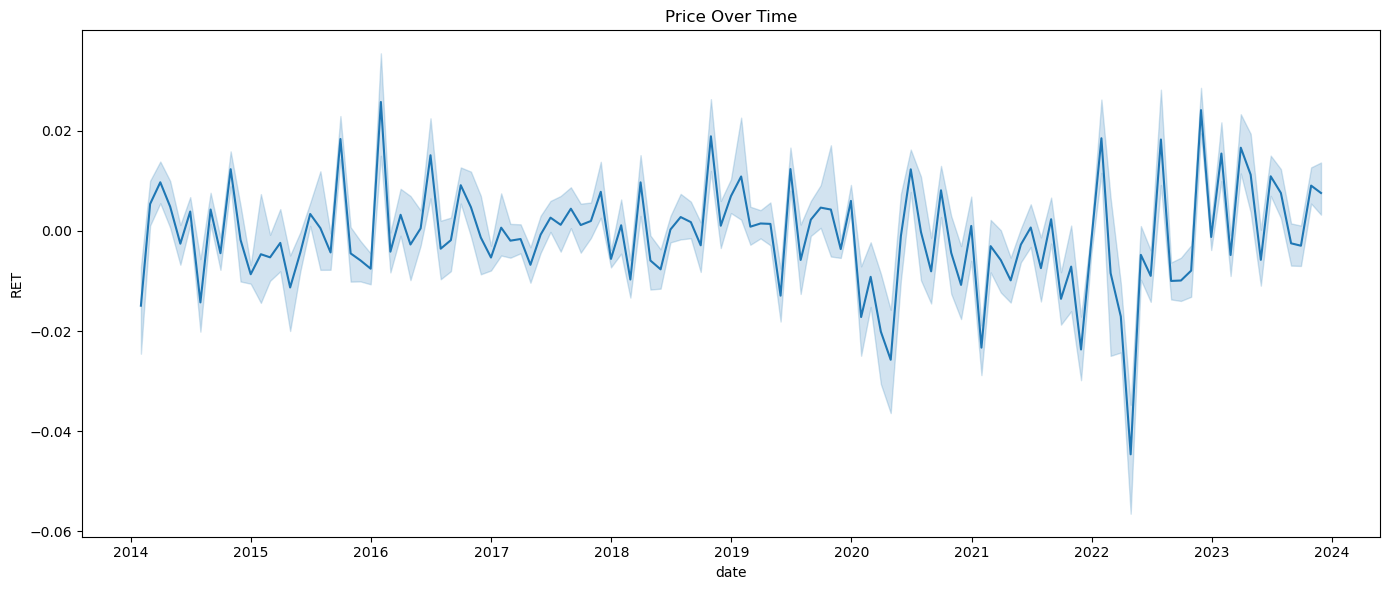

<Figure size 1500x1000 with 0 Axes>

In [364]:
# Basic statistical description
statistical_description = desc_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting CAPEI
sns.lineplot(x='date', y='RET', data=desc_data).set_title('Price Over Time')


plt.tight_layout()
plt.show()

statistical_description
plt.savefig('Price_over_time.png')


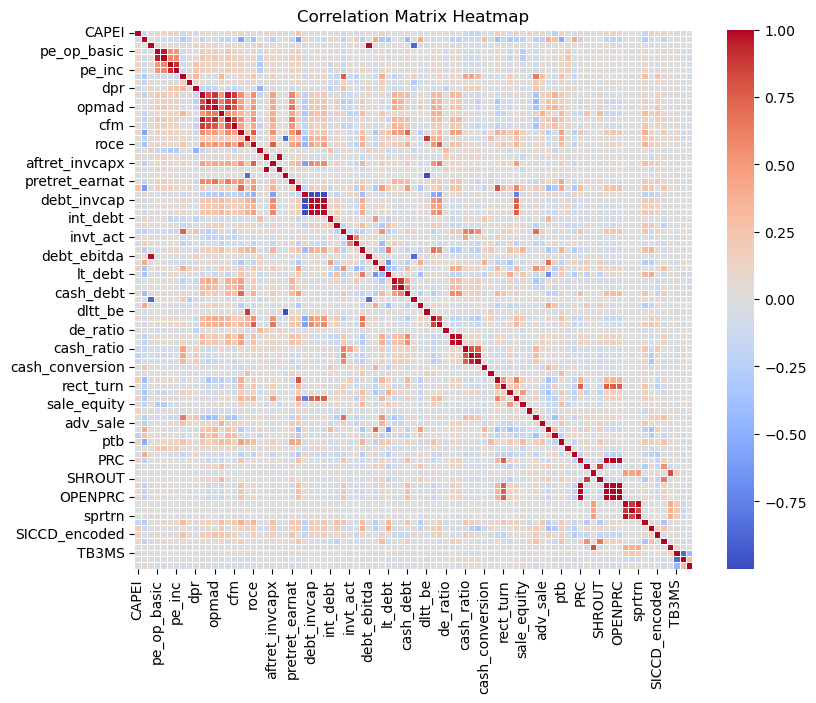

<Figure size 1500x1000 with 0 Axes>

In [365]:
# Recalculate the correlation matrix
correlation_matrix = desc_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.savefig('Correlation_matrix_heatmap.png')


/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/2512573529.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  desc_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);


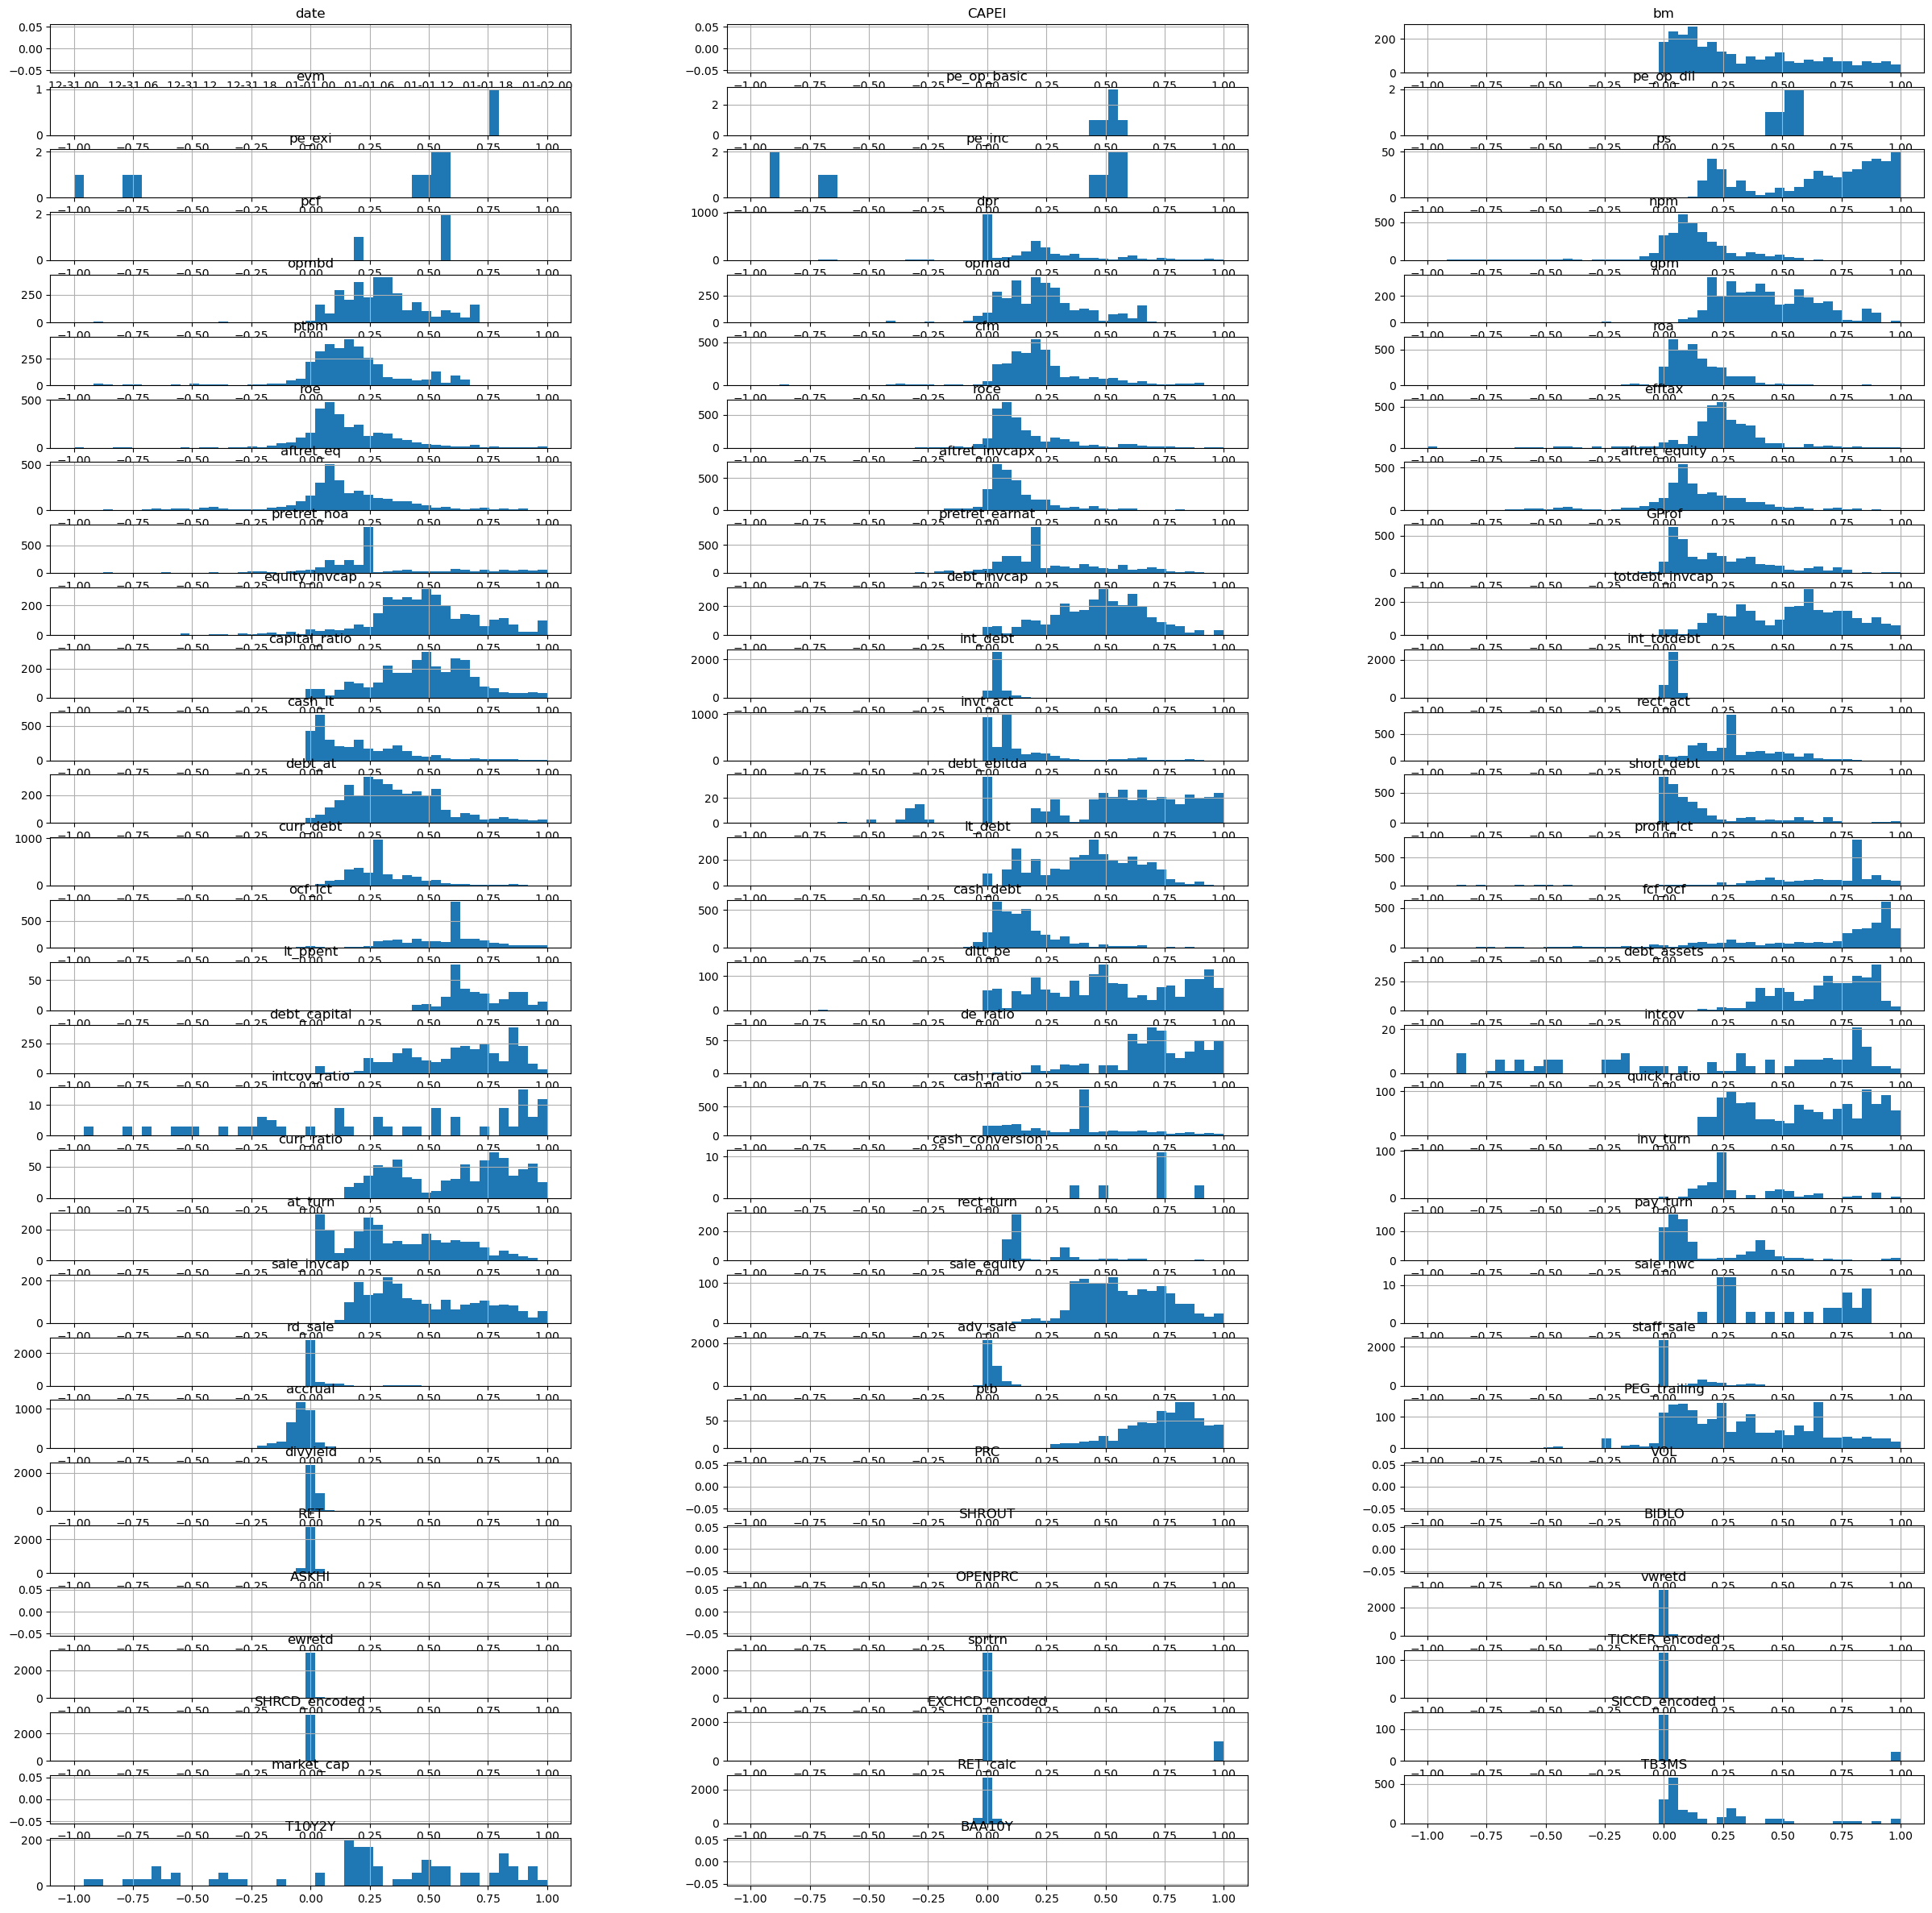

In [366]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
desc_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);
plt.savefig('numbers_over_time.png')


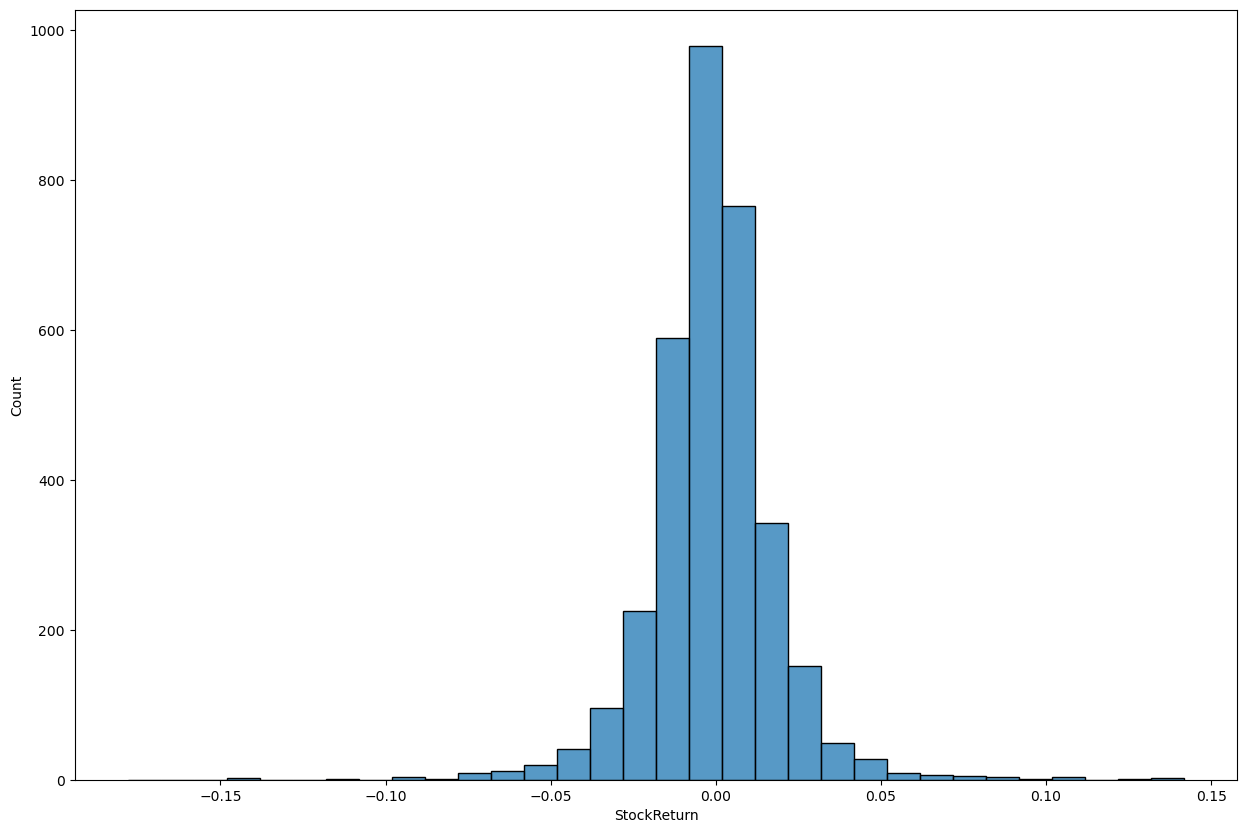

In [367]:
df_3 = desc_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.savefig('stock_return.png')


In [68]:
desc_data.columns

Index(['TICKER', 'date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'COMNAM',
       'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL', 'RET

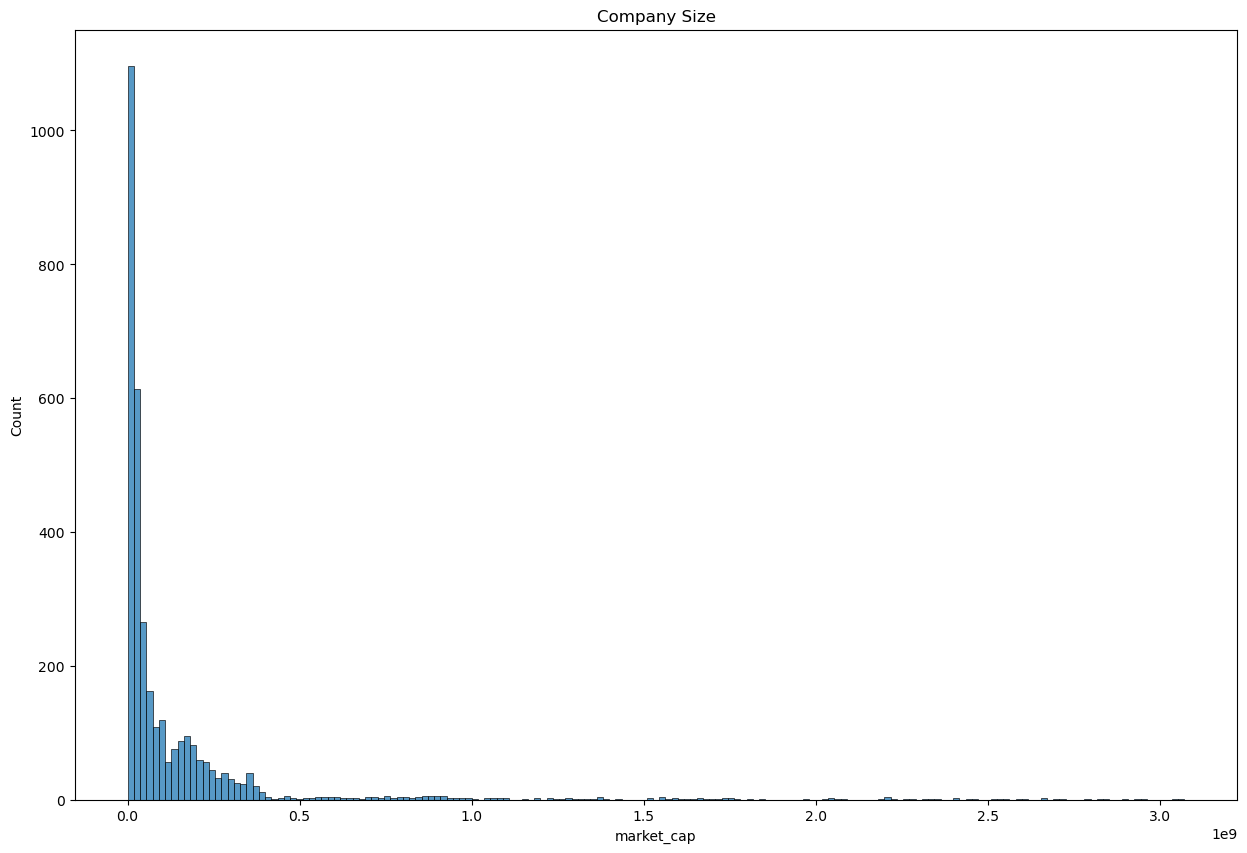

<Figure size 1500x1000 with 0 Axes>

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形的全局大小
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

# 计算最大市值
max_size = desc_data['market_cap'].max()

# 绘制直方图
ax = sns.histplot(data=desc_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Company Size')  # 设置标题

# 保存图像到当前文件夹
plt.savefig('size_distribution.png')  # 确保文件名没有拼写错误

# 显示图形
plt.show()
plt.savefig('company_size.png')


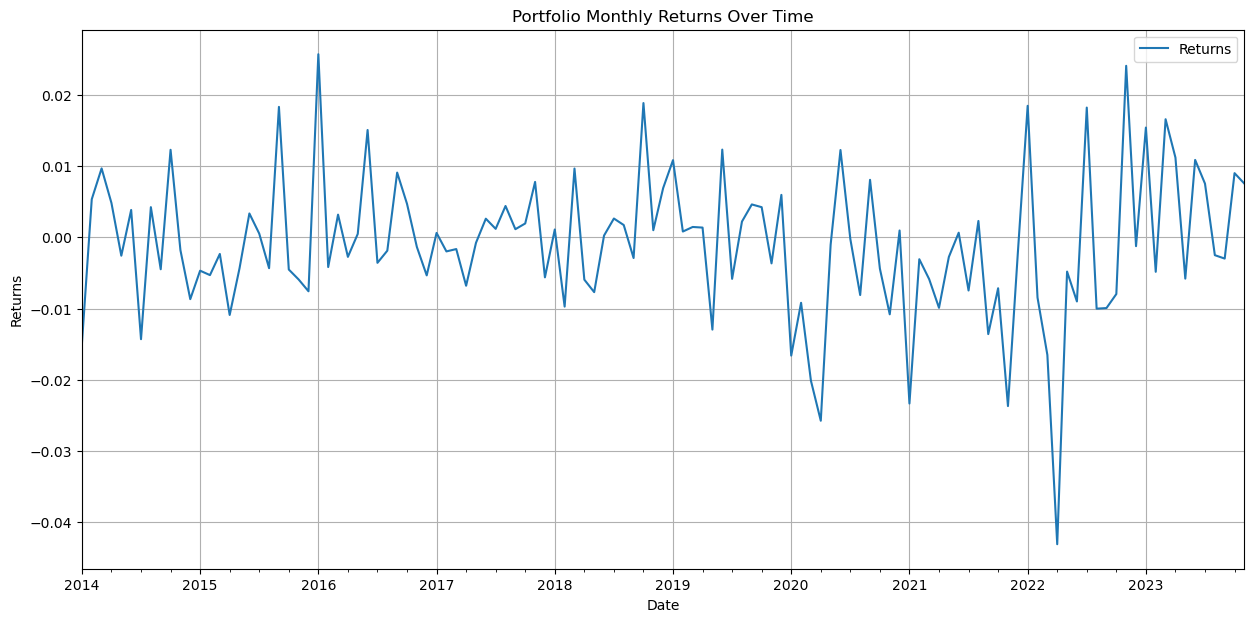

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_data is defined
ret_data = desc_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.savefig('portfolio monthly returns over time.png')


In [71]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

number_columns = desc_data.select_dtypes(include=['number'])
c = number_columns.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['Variable 1','Variable 2', 'corr']
so = so.sort_values(by = ['corr', 'Variable 1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,Variable 1,Variable 2,corr
0,PRC,BIDLO,0.999953
1,OPENPRC,ASKHI,0.999949
2,OPENPRC,BIDLO,0.999929
3,PRC,ASKHI,0.999927
4,BIDLO,ASKHI,0.999926
5,debt_invcap,capital_ratio,0.999901
6,PRC,OPENPRC,0.999865
7,equity_invcap,capital_ratio,0.999674
8,aftret_equity,aftret_eq,0.999612
9,equity_invcap,debt_invcap,0.999499


## 3.2 Feature Engineering

In [72]:
df = final_data.copy()

In [73]:
# 确保数据按 TICKER 和 date 排序
df = df.sort_values(['TICKER', 'date'])

In [74]:
existing_vars = [
    'market_cap',  # ME (Market Equity)
    'bm',          # Book-to-Market
    'pe_op_basic', # E2P (inverse)
    'pe_op_dil',   # Another version of E2P (inverse)
    'npm',         # Similar to PM (Profit Margin)
    'gpm',         # Similar to PCM (Price-to-Cost Margin)
    'roa',         # Return on Assets
    'roe',         # Return on Equity
    'ps',          # Price to Sales (inverse of S2P)
    'debt_assets', # Similar to Lev (Leverage)
    'at_turn',     # Similar to ATO (Asset Turnover)
    'accrual',     # Might correspond to OA (Operating Accruals)
    'divyield',    # Dividend Yield
]
benchmark = ['Size','Momentum','BM']

Green et al. (2017)的94个指标部分
Welch and Goyal (2008) 宏观指标：Treasury-bill rate (tbl), term spread (tms), default spread (dfy)

市场相关指标:


ME (Market Equity): 公司层面的总市值
LME: 上个月月末的总市值
LTurnover: 上月总交易量与上月月末总市值的比率
Spread: 上月日均买卖价差
Beta: 根据Frazzini和Pedersen (2014)的定义计算的贝塔值
Idio vol (Idiosyncratic Volatility): 基于Ang等(2006)方法计算的特异波动率



历史回报指标:


r2−1: 上个月的滞后回报
r12−2: 过去12个月(不包括最后一个月)的回报
r12−7: 中期动量(过去12个月到过去7个月的回报)
r36−13: 长期回报(3年前到去年的回报)


财务报表指标:


BE (Book Equity): 账面权益
BM (Book-to-Market): 账面市值比
AT: 总资产
ATO: 销售额除以净营运资产
C (Cash): 现金和短期投资占总资产比例
CTO: 资本周转率
D2A: 折旧和摊销占总资产比例
DPI2A: 固定资产变动
E2P: 市盈率的倒数
FC2Y: 费用销售比(广告、研发、销售管理费用总和除以销售额)
Free CF: 自由现金流
Investment: 总资产增长率
Lev: 杠杆率(总债务/(总债务+股东权益))
NOA: 净营运资产占滞后总资产比例
OA: 营运应计项目(根据Sloan (1996)定义)
OL: 营运杠杆(销货成本和销售管理费用除以总资产)
PCM: 价格成本利润率((销售额-销货成本)/销售额)
PM: 营业利润率(折旧后营业收入/净销售额)
Prof: 毛利润率(毛利润/权益账面价值)
Q: 托宾Q值
Rel to high: 接近52周最高价的程度
RNA: 净营运资产回报率
ROA: 资产回报率(税前利润/总资产)
ROE: 权益回报率(税前利润/滞后权益账面价值)
S2P: 销售额市值比
SGA2S: 销售管理费用率(销售管理费用/净销售额)
SUV: 标准化非预期交易量

根据Gu 2020年的论文，我们可以将特征分为以下几类：

基准特征（3个）：

规模（Size）
账面市值比（Book-to-Market ratio）
动量（Momentum）


股票水平预测器（主要分为三类）：
a. 价格趋势变量：

股票动量
行业动量
短期反转
b. 流动性变量：
市值
美元交易量
买卖价差
c. 波动性相关：
回报波动率
特质波动率
市场beta
beta平方


宏观经济预测器（8个）：

股息-价格比（Dividend-Price Ratio, dp）
收益-价格比（Earnings-Price Ratio, ep）
账面市值比（Book-to-Market Ratio, bm）
净股票发行（Net Equity Expansion, ntis）
国库券利率（Treasury-bill Rate, tbl）
期限利差（Term Spread, tms）
违约利差（Default Spread, dfy）
股票方差（Stock Variance, svar）


94个预测特征（基于Green et al. (2017)）

处理步骤：

基准特征和主要股票水平预测器：
这些特征大多可以从CRSP数据中直接计算或提取。
宏观经济预测器：
这些需要额外的宏观经济数据源，可能需要从Federal Reserve Economic Data (FRED)或其他经济数据库获取。
94个预测特征：
这些特征基于Green et al. (2017)，需要使用财务报表数据（如Compustat）结合市场数据来计算。
数据对齐：

月度特征：使用t月末的数据预测t+1月的回报
季度特征：使用至少4个月前的数据
年度特征：使用至少6个月前的数据


处理缺失值：
对于缺失的特征，使用每个月每只股票的横截面中位数进行填充

根据您提供的信息，我将帮您整理需要的变量、已有的变量和缺失的变量。

1. 需要的变量（基于您的要求）：

a. 基准特征：
   - Size (已有)
   - Book-to-Market ratio (已有，对应 'bm')
   - Momentum (已有)

b. 股票水平预测器：
   - 股票动量 (已有，对应 'Momentum')
   - 行业动量 (缺失)
   - 短期反转 (已有，对应 'ShortTermReversal')
   - 市值 (已有，对应 'ME' 或 'market_cap')
   - 美元交易量 (已有，对应 'DollarVolume')
   - 买卖价差 (已有，对应 'spread')
   - 回报波动率 (可以从 'RET' 计算)
   - 特质波动率 (已有，对应 'Idio_vol')
   - 市场beta (已有，对应 'Beta')
   - beta平方 (已有，对应 'BetaSquared')

c. 宏观经济预测器：
   - 股息-价格比 (dp) (已有，对应 'divyield')
   - 收益-价格比 (ep) (可以从 'pe_op_basic' 或 'pe_op_dil' 的倒数得到)
   - 账面市值比 (bm) (已有)
   - 净股票发行 (ntis) (缺失)
   - 国库券利率 (tbl) (可能对应 'TB3MS'，需确认)
   - 期限利差 (tms) (可能对应 'T10Y2Y'，需确认)
   - 违约利差 (dfy) (可能对应 'BAA10Y'，需确认)
   - 股票方差 (svar) (可以从 'RET' 计算)

2. 已有的重要变量（除上述外）：
   - 'roa', 'roe', 'roce' (盈利能力指标)
   - 'debt_assets', 'debt_capital', 'de_ratio' (杠杆指标)
   - 'cash_ratio', 'quick_ratio', 'curr_ratio' (流动性指标)
   - 'at_turn', 'inv_turn' (效率指标)
   - 'accrual' (质量指标)
   - 'PRC', 'VOL', 'SHROUT' (价格、交易量、股数)
   - 'vwretd', 'ewretd', 'sprtrn' (市场回报指标)

3. 缺失的重要变量：
   - 行业动量
   - 净股票发行 (ntis)

4. 可能不需要的变量（这取决于您的具体研究目的，但这些变量可能与其他变量重复或不太常用）：
   - 'CAPEI' (如果有 'pe_op_basic' 或 'pe_op_dil')
   - 'evm' (如果已有 'bm')
   - 'pe_exi', 'pe_inc' (如果已有 'pe_op_basic' 或 'pe_op_dil')
   - 'ptpm' (如果已有 'npm')
   - 'pcf' (如果已有 'ps' 和 'cfm')
   - 'aftret_eq', 'aftret_invcapx', 'aftret_equity' (如果已有 'roe' 和 'roce')
   - 'pretret_noa', 'pretret_earnat' (如果已有其他盈利能力指标)
   - 'equity_invcap', 'debt_invcap', 'totdebt_invcap' (如果已有 'debt_capital' 和 'de_ratio')
   - 'intcov', 'intcov_ratio' (可能重复)
   - 'sale_invcap', 'sale_equity', 'sale_nwc' (如果已有 'ps' 和其他效率指标)
   - 'int_debt', 'int_totdebt' (如果已有其他债务指标)
   - 'invt_act', 'rect_act' (如果已有 'curr_ratio' 和 'quick_ratio')
   - 'short_debt', 'curr_debt', 'lt_debt' (如果已有 'debt_assets' 和 'debt_capital')
   - 'ptb' (如果已有 'bm')
   - 'PEG_trailing' (如果已有 'pe_op_basic' 或 'pe_op_dil' 和增长率指标)

对于缺失的变量和需要计算的变量，您可能需要获取额外的数据或使用现有数据进行计算。例如，行业动量可能需要行业分类数据，而回报波动率和股票方差可以使用现有的回报数据计算。

In [75]:
def calculate_variables(df):
    # 0 benchmark
    df['BM'] = df['bm']
    
    # ME (Market Equity)
    df['ME'] = df['market_cap']
    # Size (natural log of ME)
    df['Size'] = np.log(df['ME'])
    
    # Momentum (11-month return, 1 month ago)
    def calculate_momentum(group):
        return group.rolling(window=11).apply(lambda x: (1 + x).prod() - 1).shift(1)

    df['Momentum'] = df.groupby('TICKER')['RET'].transform(calculate_momentum)

    # 1 市场相关指标
    # 短期反转（过去1个月的回报）
    df['ShortTermReversal'] = df.groupby('TICKER')['RET'].shift(1)
    
    # 计算市值
    df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    
    # LME (Lagged Market Equity) 上个月月末的总市值
    df['LME'] = df.groupby('TICKER')['market_cap'].shift(1)
    
    # LTurnover 上月总交易量与上月月末总市值的比率
    df['LTurnover'] = df['VOL'] / df['LME']
    
    # 美元交易量
    df['DollarVolume'] = df['PRC'].abs() * df['VOL']

    # Spread 上月日均买卖价差
    df['spread'] = (df['ASKHI'] - df['BIDLO']) / ((df['ASKHI'] + df['BIDLO']) / 2)
    
    # 计算20天滚动标准差
    df['Volatility'] = df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
    # 处理可能的 NaN 值
    df['Volatility'] = df['Volatility'].fillna(0)

    # Beta (simplified version) 用滚动算
    def calculate_beta(stock_returns, market_returns, window=252):
        return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]))
    
    df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))

    # 计算Beta平方
    df['BetaSquared'] = df['Beta'] ** 2

    # 2 历史回报指标
    # Historical returns
    df['r2_1'] = df.groupby('TICKER')['RET'].shift(1)

    # 重置索引
    df_reset = df.reset_index()
    
    # 计算 r12_2
    df_reset['r12_2'] = df_reset.groupby('TICKER')['RET'].rolling(window=11).sum().shift(1).reset_index(0, drop=True)
    df_reset['r12_7'] = df_reset.groupby('TICKER')['RET'].rolling(window=6).sum().shift(6).reset_index(0, drop=True)
    df_reset['r36_13'] = df_reset.groupby('TICKER')['RET'].rolling(window=24).sum().shift(12).reset_index(0, drop=True)

    # 设置回原来的索引
    df_reset.set_index('index', inplace=True)
    
    # 将结果赋值给原始 DataFrame
    df['r12_2'] = df_reset['r12_2']
    df['r12_7'] = df_reset['r12_7']
    df['r36_13'] = df_reset['r36_13']

    # 3 财务报表指标
    # 重置索引
    df_reset = df.reset_index()

    # Rel to high 接近52周最高价的程度
    df_reset['52_week_high'] = df_reset.groupby('TICKER')['PRC'].rolling(window=252).max().reset_index(0, drop=True)
    
    # 计算 Rel_to_high
    df_reset['Rel_to_high'] = df_reset['PRC'] / df_reset['52_week_high']
    
    # 设置回原来的索引
    df_reset.set_index('index', inplace=True)
    
    # 将结果赋值给原始 DataFrame
    df['52_week_high'] = df_reset['52_week_high']
    df['Rel_to_high'] = df_reset['Rel_to_high']
    
    # SUV (Standardized Unexplained Volume)
    def calculate_suv(volume, window=20):
        log_volume = np.log(volume)
        mean_log_volume = log_volume.rolling(window=window).mean()
        std_log_volume = log_volume.rolling(window=window).std()
        return (log_volume - mean_log_volume) / std_log_volume
    
    df['SUV'] = df.groupby('TICKER')['VOL'].apply(calculate_suv)
    
    return df

# Apply the function to your dataframe
df = calculate_variables(df)

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/742237124.py:44: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))
/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/742237124.py:93: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this war

In [76]:
# 计算缺失值统计，转换为 DataFrame
null_summary = pd.DataFrame(df.isnull().sum(), columns=['MissingValueCount'])

# 使用 option_context 临时改变显示设置并直接显示 DataFrame
with pd.option_context('display.max_columns', None,  'display.max_colwidth', 20):
    display(null_summary)

null_summary.to_csv("missing_value_summary.csv")


,MissingValueCount
TICKER,0
date,0
CAPEI,0
bm,0
evm,0
pe_op_basic,0
pe_op_dil,0
pe_exi,0
pe_inc,0
ps,0


In [77]:
def handle_missing_values(df):
    # 对历史回报指标使用前向填充
    historical_returns = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'ShortTermReversal', 'LME', 'LTurnover', 'r2_1']
    df[historical_returns] = df.groupby('TICKER')[historical_returns].fillna(method='ffill')
    df[historical_returns] = df.groupby('TICKER')[historical_returns].fillna(method='bfill')
    df[historical_returns] = df[historical_returns].fillna(df[historical_returns].median())

    
    # 对交易相关指标使用中位数填充
    trading_indicators = ['DollarVolume', 'spread']
    df[trading_indicators] = df[trading_indicators].fillna(df[trading_indicators].median())
    
    # 对SUV使用0填充
    df['SUV'] = df['SUV'].fillna(0)
    
    return df

# 应用函数
df = handle_missing_values(df)

In [95]:
def clean_and_fill_numeric(df, var):
    # 尝试将数据转换为数值型
    df[var] = pd.to_numeric(df[var], errors='coerce')    
    return df
    
# 对每个需要处理的变量应用此函数
variables_to_clean = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'sprtrn', 'RET']  # 添加所有需要处理的变量
for var in variables_to_clean:
    df = clean_and_fill_numeric(df, var)

In [96]:
print(df['Momentum'].head())  # 检查前几行数据
print(df['Momentum'].isnull().sum())  # 计算NaN的数量


0   -0.007153
1   -0.007153
2   -0.007153
3   -0.007153
4   -0.007153
Name: Momentum, dtype: float64
7


In [97]:
def handle_remaining_missing_values(df):
    # 处理 Momentum 和长期回报指标
    long_term_vars = ['Momentum', 'r12_2', 'r12_7', 'r36_13']
    for var in long_term_vars:
        df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
        df[var] = df[var].fillna('median')

    # 获取仍然缺失 Momentum 的公司
    missing_momentum_companies = df[df['Momentum'].isna()]['TICKER'].unique()
    # 使用行业平均值填充
    df['Momentum'] = df.groupby('SICCD')['Momentum'].transform(lambda x: x.fillna(x.mean()))
    # 用总体平均值填充
    df['Momentum'] = df['Momentum'].fillna(df['Momentum'].median())


    # 处理短期指标
    short_term_vars = ['ShortTermReversal', 'LME', 'LTurnover', 'r2_1']
    df[short_term_vars] = df.groupby('TICKER')[short_term_vars].fillna(method='ffill')
    df[short_term_vars] = df.groupby('TICKER')[short_term_vars].fillna(method='bfill')
    df[short_term_vars] = df[short_term_vars].fillna(df[short_term_vars].median())

    for var in short_term_vars:
        df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
    
    # 重新计算 Beta 和相关指标
    def calculate_beta(stock_returns, market_returns, window=60):
        return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]))

    df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))
    df['BetaSquared'] = df['Beta'] ** 2
    
    # 对Beta相关指标使用行业平均值填充
    beta_indicators = ['Beta', 'BetaSquared']
    for indicator in beta_indicators:
        df[indicator] = df.groupby('TICKER')[indicator].transform(lambda x: x.fillna(x.median()))
    
    # 如果仍有缺失值（例如，某些公司可能全部为NaN），使用整体中位数填充
    for indicator in beta_indicators:
        df[indicator] = df[indicator].fillna(df[indicator].median())
    
    # 用行业中位数
    # df[indicator] = df.groupby('SICCD')[indicator].transform(lambda x: x.fillna(x.mean()))
    # # 如果仍有缺失值，使用整体中位数填充
    # df[indicator] = df[indicator].fillna(df[indicator].median())

    # 对52周高点相关指标使用3个月高点替代
    df['3_month_high'] = df.groupby('TICKER')['PRC'].rolling(window=63).max().reset_index(0, drop=True)
    df['Rel_to_3month_high'] = df['PRC'] / df['3_month_high']
    
    # 使用 1 个月高点
    df['1_month_high'] = df.groupby('TICKER')['PRC'].rolling(window=21).max().reset_index(0, drop=True)
    df['Rel_to_1month_high'] = df['PRC'] / df['1_month_high']
    
    # 处理可能的缺失值
    df['52_week_high'] = df.groupby('TICKER')['52_week_high'].fillna(method='ffill',limit = 3)
    df['Rel_to_high'] = df.groupby('TICKER')['Rel_to_high'].fillna(method='ffill',limit = 3)

    # 如果还有缺失值，使用3个月高点填充52周高点
    df['52_week_high'] = df['52_week_high'].fillna(df['3_month_high'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(df['Rel_to_3month_high'])

    # 如果还有缺失值，使用1个月高点填充52周高点
    df['52_week_high'] = df['52_week_high'].fillna(df['1_month_high'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(df['Rel_to_1month_high'])

    # 如果还有缺失值，使用当前价格填充52周高点，Rel_to_high填充为1
    df['52_week_high'] = df['52_week_high'].fillna(df['PRC'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(1)
    
    return df

# 应用函数
df = handle_remaining_missing_values(df)

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/1163171179.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))


In [98]:
def calculate_rolling_beta_and_idio_vol(group, market_returns, window=60):
    # 计算滚动 Beta
    returns = group['RET']
    covariance = returns.rolling(window=window).cov(market_returns)
    market_variance = market_returns.rolling(window=window).var()
    beta = covariance / market_variance

    # 计算滚动特异波动性
    residuals = returns - beta * market_returns
    idio_vol = residuals.rolling(window=window).std()

    return pd.DataFrame({'Beta': beta, 'Idio_vol': idio_vol})

# 应用计算
result = df.groupby('TICKER').apply(
    lambda group: calculate_rolling_beta_and_idio_vol(group, df.loc[group.index, 'sprtrn'])
).reset_index(level=0, drop=True)

df['Beta'] = result['Beta']
df['Idio_vol'] = result['Idio_vol']

# 填充缺失值
for indicator in ['Beta', 'Idio_vol']:
    df[indicator] = df.groupby('TICKER')[indicator].transform(lambda x: x.fillna(x.median()))
    df[indicator] = df[indicator].fillna(df[indicator].median())

# 处理极端值 (可选)
for indicator in ['Beta', 'Idio_vol']:
    low = df[indicator].quantile(0.01)
    high = df[indicator].quantile(0.99)
    df[indicator] = df[indicator].clip(low, high)

# 计算 BetaSquared
df['BetaSquared'] = df['Beta'] ** 2

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/487766427.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  result = df.groupby('TICKER').apply(


In [99]:
def handle_missing_values_small_missing(df):
    # 处理分类变量
    category_vars = ['COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 'TICKER_encoded', 'SHRCD_encoded', 'EXCHCD_encoded', 'SICCD_encoded']
    df[category_vars] = df.groupby('TICKER')[category_vars].fillna(method='ffill')

    # 处理数值变量
    numeric_vars = ['PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd', 'sprtrn', 'RET_calc', 'RET_interp']
    df[numeric_vars] = df.groupby('TICKER')[numeric_vars].transform(lambda x: x.interpolate(method='linear'))

    # 特殊处理 RET
    df['RET'] = df.groupby('TICKER')['RET'].fillna(0)  

    # 重新计算 market_cap, ME, 和 Size
    df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    df['ME'] = df['market_cap']
    df['Size'] = np.log(df['ME'])

    return df

# 应用函数
df = handle_missing_values_small_missing(df)

In [100]:
# 计算缺失值统计，转换为 DataFrame
null_summary = pd.DataFrame(df.isnull().sum(), columns=['MissingValueCount'])

# 使用 option_context 临时改变显示设置并直接显示 DataFrame
with pd.option_context('display.max_columns', None,  'display.max_colwidth', 20):
    display(null_summary)

null_summary.to_csv("missing_value_summary.csv")


,MissingValueCount
TICKER,0
date,0
CAPEI,0
bm,0
evm,0
pe_op_basic,0
pe_op_dil,0
pe_exi,0
pe_inc,0
ps,0


In [101]:
df.set_index('date',inplace = True)

In [103]:
df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31',
               ...
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', name='date', length=3352, freq=None)

In [104]:
df.to_csv("final_data_after_missing_value_handle.csv")

In [332]:
try:
    data = data.drop(['level_0_stk','index_stk','3_month_high', 'Rel_to_3month_high', '1_month_high', 'Rel_to_1month_high', 'RET_calc', 'RET_interp'], axis=1)
except KeyError as e:
    print(f"Columns not found: {e}")
df.to_csv("merged_data_with_features.csv")

Columns not found: "['level_0_stk', 'index_stk'] not found in axis"


In [105]:
df_columns = pd.DataFrame(df.columns)
df_columns.to_csv('final_data_columns.csv')
print('output df columns')

output df columns


In [106]:
# feature_eng_df = pd.DataFrame()
# feature_eng_df['TICKER'] = df['TICKER']
# feature_eng_df['date'] = df['date']
# feature_eng_df[existing_vars] = df[existing_vars]


In [107]:
# # 对于月度特征，使用当前月的数据
# # 对于季度特征，使用4个月前的数据
# sto_data_selected['QuarterlyFeature_Lagged'] = sto_data_selected.groupby('PERMNO')['QuarterlyFeature'].shift(4)

# # 对于年度特征，使用6个月前的数据
# sto_data_selected['AnnualFeature_Lagged'] = sto_data_selected.groupby('PERMNO')['AnnualFeature'].shift(6)

## 3.3 Model Training

## Normalization(FR)

In [302]:
data = df.copy()

In [303]:
try:
    data = data.drop(['level_0_stk','index_stk','3_month_high', 'Rel_to_3month_high', '1_month_high', 'Rel_to_1month_high', 'RET_calc', 'RET_interp'], axis=1)
except KeyError as e:
    print(f"Columns not found: {e}")


Columns not found: "['level_0_stk', 'index_stk'] not found in axis"


In [304]:
data.columns

Index(['TICKER', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'pe_inc', 'ps', 'pcf',
       ...
       'r12_7', 'r36_13', '52_week_high', 'Rel_to_high', 'SUV', '3_month_high',
       'Rel_to_3month_high', '1_month_high', 'Rel_to_1month_high', 'Idio_vol'],
      dtype='object', length=118)

In [305]:
data.describe()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,PRC,VOL,RET,SHROUT,BIDLO,ASKHI,OPENPRC,vwretd,ewretd,sprtrn,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,TB3MS,T10Y2Y,BAA10Y,BM,ME,Size,Momentum,LME,LTurnover,DollarVolume,spread,Volatility,Beta,BetaSquared,52_week_high,Rel_to_high,SUV,3_month_high,Rel_to_3month_high,1_month_high,Rel_to_1month_high,Idio_vol
count,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3.352000e+03,3352.000000,3.352000e+03,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3352.0,3352.000000,3352.000000,3.352000e+03,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3.352000e+03,3352.000000,3352.000000,3.345000e+03,3345.000000,3.352000e+03,3352.000000,3352.000000,3352.000000,3352.000000,3345.000000,3352.000000,3352.000000,1319.000000,1319.000000,2621.000000,2621.000000,3352.000000
mean,31.958720,0.542949,12.008982,14.112428,14.163760,16.545729,18.336471,4.169608,13.989193,0.397618,0.127597,0.298683,0.226827,0.441569,0.170659,0.225396,0.142342,0.498322,0.208124,0.243414,0.129848,0.190231,0.127885,-2.699061,0.268930,0.239113,0.245119,0.729474,0.947657,0.738253,0.050991,0.036349,0.243856,0.156192,0.313847,0.366694,4.025536,0.173186,0.305074,0.419925,0.867810,0.663785,0.166463,0.633131,33.180558,4.228021,0.737651,0.750854,3.124102,11.150847,14.159911,0.631096,1.153617,1.357577,99.583309,31.061965,0.626007,27.261473,8.943657,1.225289,4.888976,13.439577,0.015273,0.019844,0.067197,-0.043034,8.019326,1.783859,0.013977,247.104739,1.076732e+07,-0.000968,1.549566e+06,244.308780,250.199618,247.331219,-0.000540,0.000036,-0.000764,21.754475,0.0,0.296539,23.340990,1.462026e+08,-0.001401,1.274791,0.698567,2.294891,0.542949,1.462026e+08,17.486609,-0.011927,1.450207e+08,0.217304,1.055338e+09,0.022969,0.017288,0.995270,1.071112,301.252449,0.862937,0.005341,506.004717,0.781333,350.057809,0.848721,0.015240
std,157.018292,0.496675,141.142298,56.647485,56.913547,65.455845,63.826364,7.829604,37.215023,2.733596,0.185347,0.199035,0.214434,0.202618,0.219502,0.202277,0.124506,1.989518,0.322075,1.147141,2.146488,0.445211,2.145672,122.882474,0.222261,0.205202,1.704557,1.707110,2.503561,1.706828,0.066056,0.017266,0.363262,0.413253,0.243291,0.205056,39.514155,0.217877,0.141536,0.209250,0.547988,0.435071,0.179008,3.459712,86.804949,79.706523,0.256400,0.680679,37.412745,21.632455,29.190127,0.793634,0.735339,0.827662,256.282500,151.941908,0.680506,71.868440,12.852713,1.926097,15.342733,40.775010,0.048810,0.026657,0.113659,0.050733,13.056972,6.230501,0.016303,706.875387,2.043282e+07,0.019259,2.680680e+06,698.759803,715.894933,7

In [ ]:
# description = data.describe()
# description.to_csv('data_description.csv')


In [306]:
# handle fin related data
# 处理无穷大和NaN值
data = data.replace([np.inf, -np.inf], np.nan)

# 创建一个新的DataFrame来存储归一化后的数据
normalized_data = pd.DataFrame(index=data.index)


# 1. MinMaxScaler用于大多数财务比率
minmax_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'dpr', 'npm', 
               'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax']
minmax_scaler = MinMaxScaler()
for date in normalized_data.index.unique():
    normalized_data[minmax_cols] = minmax_scaler.fit_transform(data[minmax_cols].fillna(data[minmax_cols].mean()))

# 2. 对数转换后StandardScaler用于严重偏斜的正值数据
log_standard_cols = ['ps', 'pcf', 'debt_ebitda', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio']
log_standard_scaler = StandardScaler()
for col in log_standard_cols:
    for date in normalized_data.index.unique():
        # 将负值设为很小的正数
        temp_data = data[col].clip(lower=1e-8)
        normalized_data[col] = log_standard_scaler.fit_transform(np.log1p(temp_data).values.reshape(-1, 1))

# 3. Yeo-Johnson变换用于可能包含负值的财务指标
yeojohnson_cols = ['aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf']
pt_yeo = PowerTransformer(method='yeo-johnson')
for date in normalized_data.index.unique():
    normalized_data[yeojohnson_cols] = pt_yeo.fit_transform(data[yeojohnson_cols].fillna(data[yeojohnson_cols].mean()))

# 4. 对于0-1之间的比率数据，使用缩放而不是logit转换
ratio_cols = ['equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio']
ratio_scaler = MinMaxScaler(feature_range=(0.001, 0.999))  # 避免0和1
for date in normalized_data.index.unique():
    normalized_data[ratio_cols] = ratio_scaler.fit_transform(data[ratio_cols].fillna(data[ratio_cols].mean()))

# 5. 对于周转率和转换天数，使用Yeo-Johnson而不是Box-Cox
turn_cols = ['inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'cash_conversion']
pt_yeo_turn = PowerTransformer(method='yeo-johnson')
for date in normalized_data.index.unique():
    normalized_data[turn_cols] = pt_yeo_turn.fit_transform(data[turn_cols].fillna(data[turn_cols].mean()))

# 6. QuantileTransformer用于可能存在极端值的指标
quantile_cols = ['intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc']
qt = QuantileTransformer(output_distribution='normal')
for date in normalized_data.index.unique():
    normalized_data[quantile_cols] = qt.fit_transform(data[quantile_cols].fillna(data[quantile_cols].mean()))

# 7. RobustScaler用于其他可能包含异常值的列
robust_cols = ['int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 
               'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield']
robust_scaler = RobustScaler()
for date in normalized_data.index.unique():
    normalized_data[robust_cols] = robust_scaler.fit_transform(data[robust_cols].fillna(data[robust_cols].mean()))

# 检查是否所有列都已处理
unprocessed_cols = set(numeric_columns) - set(normalized_data.columns)
if unprocessed_cols:
    print(f"Warning: The following columns were not processed: {unprocessed_cols}")
    # 对于未处理的列，可以选择直接复制原始值或应用默认的StandardScaler
    for col in unprocessed_cols:
        for date in normalized_data.index.unique():
            normalized_data[col] = StandardScaler().fit_transform(data[[col]].fillna(data[col].mean()))



In [307]:
normalized_data.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31',
               ...
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', name='date', length=3352, freq=None)

In [ ]:
# normalized_data.columns

In [308]:
# handle stock and econ related data

# 创建归一化器
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# 选择需要进行 Min-Max 归一化的特征
min_max_features = [
    'vwretd', 'ewretd', 'sprtrn',
    'Beta', 'BetaSquared', 'Idio_vol', 'spread', 'BM', 'ME', 'Size',
    'Momentum', 'ShortTermReversal', 'LME', 'LTurnover'
]

# 选择需要进行 Z-score 标准化的特征
z_score_features = [
    'PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC',
    'market_cap', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'DollarVolume'
]

# 进行 Min-Max 归一化
for date in normalized_data.index.unique():
    normalized_data[min_max_features] = min_max_scaler.fit_transform(data[min_max_features])

# 进行 Z-score 标准化
for date in normalized_data.index.unique():
    normalized_data[z_score_features] = standard_scaler.fit_transform(data[z_score_features])

# 显示归一化后的数据
print(normalized_data.head())


               CAPEI        bm       evm  pe_op_basic  pe_op_dil    pe_exi  \
date                                                                         
2014-01-31  0.648127  0.109275  0.823512     0.609655   0.603404  0.671375   
2014-02-28  0.648420  0.098820  0.823470     0.599556   0.593340  0.662848   
2014-03-31  0.648352  0.098820  0.823470     0.599564   0.593347  0.662855   
2014-04-30  0.648803  0.098820  0.823470     0.599603   0.593387  0.662889   
2014-05-31  0.648847  0.100843  0.823490     0.599618   0.593401  0.662900   

              pe_inc       dpr       npm     opmbd     opmad       gpm  \
date                                                                     
2014-01-31  0.636211  0.238657  0.725402  0.763207  0.755639  0.573314   
2014-02-28  0.627453  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-03-31  0.627459  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-04-30  0.627494  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-05-3

Rank standardization in inreval [-1,1]
A rank standardization procedure following Kelly, Pruitt, and Su (2019) and Freyberger, Neuhierl, and Weber (2020) is employed. The stock characteristics are ranked month-by-month cross-sectionally and the ranks are mapped into the [-1,1] interval, thereby transforming features into a uniform distribution and increasing the insensitivity to outliers

In [309]:
temp_nor_data = normalized_data.copy()

In [311]:
all_features = (minmax_cols + log_standard_cols + yeojohnson_cols +
                ratio_cols + turn_cols + quantile_cols + robust_cols +
                min_max_features + z_score_features)

# 对每个月（由 'eom' 列指示的月份）进行分组，然后对这些特征进行百分比排名
temp_nor_data[all_features] = temp_nor_data[all_features].rank(pct=True)

# 将排名转换为 [-1, 1] 区间
temp_nor_data[all_features] = 2 * temp_nor_data[all_features] - 1

# 检查转换结果
print(temp_nor_data[all_features].head())


               CAPEI        bm       evm  pe_op_basic  pe_op_dil    pe_exi  \
date                                                                         
2014-01-31 -0.215692 -0.090394 -0.720764    -0.315632  -0.322792 -0.306683   
2014-02-28 -0.167661 -0.112768 -0.760143    -0.813842  -0.812053 -0.774463   
2014-03-31 -0.181384 -0.112768 -0.760143    -0.813246  -0.811456 -0.773866   
2014-04-30 -0.106802 -0.112768 -0.760143    -0.812649  -0.810859 -0.773270   
2014-05-31 -0.099344 -0.109189 -0.739857    -0.812053  -0.810263 -0.772673   

              pe_inc       dpr       npm     opmbd     opmad       gpm  \
date                                                                     
2014-01-31 -0.289379  0.361277  0.549523  0.194212  0.365752  0.003878   
2014-02-28 -0.781623  0.374105  0.524165  0.188544  0.338604  0.003878   
2014-03-31 -0.781026  0.374105  0.524165  0.188544  0.338604  0.003878   
2014-04-30 -0.780430  0.374105  0.524165  0.188544  0.338604  0.003878   
2014-05-3

In [312]:
temp_nor_data['TICKER'] = data['TICKER']
temp_nor_data['RET'] = data['RET']

In [313]:
# 保存归一化后的数据
temp_nor_data.to_csv('temp_nor_data.csv', index=False)

print("Normalization completed. Data saved to 'normalized_data.csv'")

Normalization completed. Data saved to 'normalized_data.csv'


# Model Training

In [314]:
model_data = temp_nor_data.copy()


In [315]:
# 可能需要删除的变量
variables_to_drop = [
    'CAPEI', 'evm', 'pe_exi', 'pe_inc', 'ptpm', 'pcf',
    'aftret_eq', 'aftret_invcapx', 'aftret_equity',
    'pretret_noa', 'pretret_earnat',
    'equity_invcap', 'debt_invcap', 'totdebt_invcap',
    'intcov', 'intcov_ratio',
    'sale_invcap', 'sale_equity', 'sale_nwc',
    'int_debt', 'int_totdebt',
    'invt_act', 'rect_act',
    'short_debt', 'curr_debt', 'lt_debt',
    'ptb', 'PEG_trailing'
]

# 需要保留的变量
variables_to_keep = [
    # 基准特征
    'Size', 'bm', 'Momentum',
    
    # 股票水平预测器
    'ShortTermReversal', 'ME', 'market_cap', 'DollarVolume', 'spread',
    'RET', 'Idio_vol', 'Beta', 'BetaSquared',
    
    # 宏观经济预测器
    'divyield', 'pe_op_basic', 'pe_op_dil', 'TB3MS', 'T10Y2Y', 'BAA10Y',
    
    # 其他重要财务指标
    'roa', 'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio',
    'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn',
    'accrual',
    
    # 价格和交易相关
    'PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC',
    
    # 市场回报指标
    'vwretd', 'ewretd', 'sprtrn',
    
    # 其他可能有用的指标
    'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'cfm', 'efftax', 'ps',
    'debt_ebitda', 'lt_ppent', 'dltt_be', 'capital_ratio',
    'rect_turn', 'pay_turn', 'cash_conversion',
    'cash_lt', 'debt_at', 'profit_lct', 'ocf_lct',
    'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale',
    
    # 其他计算得到的指标
    'LME', 'LTurnover',
    
    # 标识符
    'TICKER'
]

# 使用这些列表来选择或删除变量
# model_data = model_data[variables_to_keep]
# 全部保留

# # 或者
# df_dropped = df.drop(columns=variables_to_drop)

# 打印列表长度，以检查
# print(f"Number of variables to drop: {len(variables_to_drop)}")
# print(f"Number of variables to keep: {len(variables_to_keep)}")

# try:
#     rf_data = rf_data.drop([''], axis=1)
# except KeyError as e:
#     print(f"Columns not found: {e}")

#因为结果不好所以不选择变量了

In [316]:
model_data.columns

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'ps', 'pcf', 'debt_ebitda', 'lt_ppent', 'dltt_be',
       'debt_assets', 'debt_capital', 'de_ratio', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'cash_conversion', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
       'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual',
       'ptb', 'PEG_trailing', 'divyield', 'vwretd', 'ewretd', 'sprtrn', 'Beta',
       'BetaSquared', 'Idio_vol', 'spread',

In [317]:
columns_have_nan = ['ShortTermReversal','LME','LTurnover']
try:
    model_data[columns_have_nan] = model_data[columns_have_nan].fillna(model_data[columns_have_nan].mean())
except KeyError as e:
    print(f"Columns not found: {e}")


In [318]:
# 定义不需要滞后的变量
non_lag_variables = ['TICKER', 'RET']

variables_to_keep = model_data.columns

# 定义需要滞后的变量
lag_variables = [var for var in variables_to_keep if var not in non_lag_variables]

# 假设model_data是一个包含所有数据的DataFrame，并且已经按日期和TICKER排序

# 对需要滞后的变量进行滞后处理
for var in lag_variables:
    model_data[f'{var}_lag'] = model_data.groupby('TICKER')[var].shift(1)

# 删除原始的非滞后变量（除了不需要滞后的变量）
model_data = model_data.drop(columns=lag_variables)

# 重命名滞后变量，去掉"_lag"后缀
model_data = model_data.rename(columns={f'{var}_lag': var for var in lag_variables})

# 删除包含NaN值的行（由于滞后处理产生的第一个时间点）
model_data = model_data.dropna()

# 最终的model_data将包含所有滞后处理后的变量和不需要滞后的变量

In [321]:
model_data.describe()

,RET,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,ps,pcf,debt_ebitda,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,inv_turn,at_turn,rect_turn,pay_turn,cash_conversion,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,sale_invcap,sale_equity,sale_nwc,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,vwretd,ewretd,sprtrn,Beta,BetaSquared,Idio_vol,spread,BM,ME,Size,Momentum,ShortTermReversal,LME,LTurnover,PRC,VOL,SHROUT,BIDLO,ASKHI,OPENPRC,market_cap,TB3MS,T10Y2Y,BAA10Y,DollarVolume
count,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000
mean,-0.000865,0.001879,-0.000810,0.002173,-0.000274,-0.000290,0.000332,-0.000199,-0.001071,0.000438,0.000998,0.000613,0.000373,0.000916,0.000697,0.000342,0.000310,-0.000154,0.003029,0.001955,0.001106,0.000646,0.000109,0.000354,0.000736,0.000625,0.000170,-0.000439,-0.000016,-0.000398,-0.000095,-0.000817,0.000127,0.000420,0.000406,0.000577,0.000384,0.001553,0.000017,0.000294,0.000204,-0.000504,0.000698,0.000662,0.002117,0.000736,0.000812,-0.000112,0.000370,-0.000383,-0.001359,-0.001837,0.001371,0.000737,-0.001372,0.000326,0.001007,0.000251,-0.000127,-0.000965,-0.000975,0.000784,0.000479,0.000108,0.000704,0.000255,0.000178,0.001381,-0.000114,-0.000319,-0.004030,-0.002166,-0.004059,0.000398,0.000398,0.000298,0.001058,-0.000810,0.001427,0.001427,-0.004902,-0.004049,0.000912,-0.001127,0.000167,-0.000520,0.001581,0.000188,0.000182,0.000187,0.001427,-0.008160,0.007342,0.008677,-0.000742
std,0.019186,0.577013,0.576924,0.576990,0.577637,0.577628,0.577789,0.577806,0.571028,0.577971,0.577985,0.578360,0.577850,0.578263,0.577603,0.577583,0.577644,0.578186,0.577885,0.576712,0.577192,0.577619,0.577671,0.577413,0.577201,0.577317,0.577100,0.577617,0.577751,0.577579,0.574166,0.574246,0.577790,0.577447,0.577304,0.577075,0.577396,0.574266,0.577947,0.578064,0.577591,0.558074,0.577787,0.577591,0.574314,0.574432,0.574308,0.578074,0.578007,0.560625,0.576984,0.577191,0.577398,0.568625,0.573931,0.577040,0.577548,0.574558,0.577093,0.574092,0.573980,0.577471,0.577809,0.444200,0.553519,0.468541,0.577649,0.576804,0.577113,0.564541,0.578409,0.579711,0.578372,0.577598,0.577598,0.570938,0.578641,0.576924,0.577015,0.577015,0.577123,0.577177,0.576750,0.576596,0.577424,0.576871,0.577157,0.577416,0.577424,0.577417,0.577015,0.572633,0.575282,0.573341,0.577405
min,-0.178105,-0.999403,-0.987172,-0.998807,-0.999403,-0.999403,-0.999403,-0.999403,-0.999403,-0.997912,-0.998807,-0.997912,-0.998807,-0.998807,-0.998807,-0.998807,-0.999403,-0.998807,-0.999403,-0.999105,-0.949582,-0.975835,-0.998807,-0.968675,-0.998807,-0.998807,-0.920943,-0.998807,-0.9988

## OLS

In [322]:
ols_data = model_data.copy()

In [323]:
ols_data.columns

Index(['TICKER', 'RET', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm',
       'cfm', 'roa', 'roe', 'roce', 'efftax', 'ps', 'pcf', 'debt_ebitda',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa',
       'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap',
       'totdebt_invcap', 'capital_ratio', 'inv_turn', 'at_turn', 'rect_turn',
       'pay_turn', 'cash_conversion', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
       'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual',
       'ptb', 'PEG_trailing', 'divyield', 'vwretd', 'ewretd', 'sprtrn', 'Beta',
       'BetaSquared', 'Idi

In [324]:
#Define the idependent variables (X) and the dependent variable (y)
features = ols_data.columns[~ols_data.columns.isin(['TICKER','RET'])].tolist()
X = ols_data[features]
y = ols_data['RET']

In [325]:
X.head()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,ps,pcf,debt_ebitda,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,inv_turn,at_turn,rect_turn,pay_turn,cash_conversion,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,sale_invcap,sale_equity,sale_nwc,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,vwretd,ewretd,sprtrn,Beta,BetaSquared,Idio_vol,spread,BM,ME,Size,Momentum,ShortTermReversal,LME,LTurnover,PRC,VOL,SHROUT,BIDLO,ASKHI,OPENPRC,market_cap,TB3MS,T10Y2Y,BAA10Y,DollarVolume
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-28,-0.215692,-0.090394,-0.720764,-0.315632,-0.322792,-0.306683,-0.289379,0.361277,0.549523,0.194212,0.365752,0.003878,0.606205,0.331146,0.767601,0.349940,0.738663,0.129773,0.238067,-0.228819,-0.921241,-0.254177,-0.863365,-0.874702,-0.914081,-0.723449,0.510740,0.731802,0.520286,0.772375,0.795943,0.446897,0.916169,-0.904535,-0.946301,-0.904535,0.880072,0.659606,0.073986,0.136038,0.070107,1.000000,1.000000,0.637828,0.704952,0.683771,0.498807,-0.088305,-0.496122,-0.886038,-0.756265,0.781623,-0.426611,0.258950,-0.913186,-0.90543,0.843675,-0.591289,0.726730,0.867542,0.963305,0.186158,0.696002,-0.055191,-0.301014,-0.687649,0.105012,-0.353520,0.541468,-0.475239,-0.608294,-0.524761,0.335322,0.335322,0.680788,-0.284010,-0.090394,0.882458,0.882458,0.035501,0.175187,0.883109,-0.622422,0.862172,0.706444,0.280728,0.862172,0.860979,0.861575,0.882458,-0.630370,0.992542,0.336814,0.949284
2014-03-31,-0.167661,-0.112768,-0.760143,-0.813842,-0.812053,-0.774463,-0.781623,0.374105,0.524165,0.188544,0.338604,0.003878,0.577566,0.322494,0.754773,0.321599,0.720764,0.129773,0.258950,-0.173031,-0.936754,-0.258950,-0.878282,-0.919153,-0.958234,-0.761337,0.480907,0.668556,0.488663,0.735979,0.759845,0.478520,0.923628,-0.921241,-0.955251,-0.921241,0.823986,0.630072,0.166468,0.161098,0.070107,0.991647,0.991647,0.659606,0.711814,0.693019,0.516110,-0.097852,-0.472852,-0.856504,-0.717780,0.806683,-0.426611,-0.264021,-0.941527,-0.90543,0.867542,-0.673329,0.775358,0.886337,0.963305,0.208532,0.701671,-0.055191,-0.301014,-0.610084,0.102625,-0.842482,0.517005,0.315931,-0.039081,0.382160,0.335322,0.335322,0.680788,0.081742,-0.112768,0.884845,0.884845,0.035501,0.175187,0.883109,-0.622422,0.865752,0.590095,0.280728,0.865752,0.865752,0.865752,0.884845,-0.538484,0.977029,0.417959,0.928998
2014-04-30,-0.181384,-0.112768,-0.760143,-0.813246,-0.811456,-0.773866,-0.781026,0.374105,0.524165,0.188544,0.338604,0.003878,0.577566,0.322494,0.754773,0.321599,0.720764,0.129773,0.252088,-0.187947,-0.936754,-0.258950,-0.878282,-0.919153,-0.958234,-0.761337,0.480907,0.668556,0.488663,0.735979,0.759845,0.478520,0.923628,-0.921241,-0.955251,-0.921241,0.823986,0.630072,0.166468,0.161098,0.070107,0.991647,0.991647,0.659606,0.711814,0.693019,0.516110,-0.097852,-0.472852,-0.856504,-0.717780,0.806683,-0.426611,-0.264021,-0.941527,-0.90543,0.867542,-0.673329,0.775358,0.886337,0.963305,0.208532,0.701671,-0.055191,-0.301014,-0.610084,0.095465,-0.840692,0.504475,0.772375,0.891110,0.653043,0.335322,0.335322,0.680788,-0.867542,-0.112768,0.883055,0.883055,0.035501,-0.101345,0.885800,-0.842152,0.866945,0.284010,0.267303,0.867542,0.866348,0.867542,0.883055,-0.538484,0.961516,0.369033,0.872912
2014-05-31,-0.106802,-0.112768,-0.760143,-0.812649,-0.810859,-0.773270,-0.780430,0.374105,0.524165,0.188544,0.338604,0.003878,0.577566,0.322494,0.754773,0.321599,0.720764,0.129773,0.304594,-0.117542,-0.936754,-0.258950,-0.878282,-0.919153,-0.958234,-0.761337,0.480907,0.668556,0.488663,0.735979,0.759845,0.478520,0.923628,-0.921241,-0.955251,-0.921241,0.823986,0.630072,0.166468,0.161098,0.070107,0.991647,0.991647,0.6596

In [326]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the train and test sets
X_train.shape, X_test.shape 


((2651, 94), (663, 94))

In [360]:
# L1正则化
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Initialize the Lasso regression model with an alpha value
lasso_model = Lasso(alpha=0.0005, random_state=42)

# Train the Lasso model
lasso_model.fit(X_train, y_train)

print("Training score:", lasso_model.score(X_train, y_train))
print("Test score:", lasso_model.score(X_test, y_test))


Training score: 0.01893424012089584
Test score: -0.1983261747747942


In [361]:
print("Number of features used:", np.sum(lasso_model.coef_ != 0))
print("Selected features:", [features[i] for i, coef in enumerate(lasso_model.coef_) if coef != 0])


Number of features used: 9
Selected features: ['efftax', 'aftret_eq', 'intcov', 'accrual', 'divyield', 'spread', 'Momentum', 'TB3MS', 'BAA10Y']


In [362]:
# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)

mse_lasso, mape_lasso

(0.0003213230481148018, 1.1467827184782495)

In [363]:
# 获取系数，并找到非零系数
coefficients = lasso_model.coef_
non_zero_indices = np.where(coefficients != 0)[0]  # 非零系数的索引

# 构建 Lasso 模型表达式
terms = [f"({coefficients[idx]:.3f} * {features[idx]})" for idx in non_zero_indices]
expression = " + ".join(terms)

# 确保 intercept 是标量
intercept = lasso_model.intercept_
if isinstance(intercept, np.ndarray):
    intercept = intercept.item()

if intercept != 0:
    expression += f" + {intercept:.3f}"

print("Lasso模型表达式: Price = ", expression, "\n")
print("包含的特征和系数:", {features[idx]: coefficients[idx] for idx in non_zero_indices})


Lasso模型表达式: Price =  (0.001 * efftax) + (-0.000 * aftret_eq) + (-0.000 * intcov) + (-0.001 * accrual) + (-0.000 * divyield) + (-0.002 * spread) + (0.001 * Momentum) + (0.001 * TB3MS) + (0.001 * BAA10Y) + -0.002 

包含的特征和系数: {'efftax': 0.0007053366744940357, 'aftret_eq': -7.597566023825413e-05, 'intcov': -0.0001189337025169207, 'accrual': -0.0006244362250963634, 'divyield': -0.00016251756216056535, 'spread': -0.0015411926196334217, 'Momentum': 0.000732659764477616, 'TB3MS': 0.0005977214784331546, 'BAA10Y': 0.0006109094906901871}


## Random Forest

In [331]:
rf_data = model_data.copy()


In [333]:
#Define the idependent variables (X) and the dependent variable (y)
features = rf_data.columns[~rf_data.columns.isin(['TICKER','RET'])].tolist()
X = rf_data[features]
y = rf_data['RET']

# 逆变换整个数据集
# y_and_many_inversed = min_max_scaler.inverse_transform(rf_data[min_max_features])

# 如果你只需要 RET 列的原始值，你应该先确定它在 features 中的位置
# ret_index = min_max_features.index('RET')  # 获取RET在features列表中的位置
# y = y_and_many_inversed[:, ret_index]  # 获取逆变换后的RET列


In [334]:
# 看特征
# 创建随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 获取特征重要性并排序
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# 显示特征重要性
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({feature_importances[indices[f]]}) - {features[indices[f]]}")

# 可以基于特征重要性进行特征选择，例如选择重要性最高的N个特征
selected_features = indices[:10]  # 选择重要性排名前3的特征


Feature ranking:
1. feature 71 (0.05446129482109865) - sprtrn
2. feature 69 (0.05162348287348191) - vwretd
3. feature 70 (0.04586886110413622) - ewretd
4. feature 92 (0.04122584182037673) - BAA10Y
5. feature 90 (0.04062546593347725) - TB3MS
6. feature 91 (0.03745989719777674) - T10Y2Y
7. feature 80 (0.034578185764136474) - ShortTermReversal
8. feature 75 (0.03456364368774144) - spread
9. feature 79 (0.034331916113190725) - Momentum
10. feature 82 (0.02063588702032715) - LTurnover
11. feature 17 (0.01995415789604041) - efftax
12. feature 93 (0.017988214382361) - DollarVolume
13. feature 0 (0.016247739934013728) - CAPEI
14. feature 18 (0.016099301931351118) - ps
15. feature 3 (0.014389835762995046) - pe_op_basic
16. feature 48 (0.013910445903586185) - sale_nwc
17. feature 84 (0.01374950250293774) - VOL
18. feature 19 (0.013672262101371445) - pcf
19. feature 65 (0.013214403690736282) - accrual
20. feature 4 (0.012796143808648727) - pe_op_dil
21. feature 66 (0.012340207974666135) - ptb
22.

In [335]:
print("Selected features:", [features[i] for i in selected_features])


Selected features: ['sprtrn', 'vwretd', 'ewretd', 'BAA10Y', 'TB3MS', 'T10Y2Y', 'ShortTermReversal', 'spread', 'Momentum', 'LTurnover']


sprtrn - S&P Total Return:

这个指标通常代表标准普尔500指数的总回报率。总回报率包括股息再投资的影响，这是评估股市表现的一个重要指标。

vwretd - Volume Weighted Return Difference:

这是一个基于成交量加权的回报率差异指标，用于评估在特定时间内基于交易量加权的平均回报。

ewretd - Equal Weighted Return Difference:

这表示等权重配置的投资组合的回报率差异，每个组成部分的权重相等，用于评估所有股票同等重要的场景下的表现。

BAA10Y - BAA Corporate Bonds relative to 10 Years Treasury:

这个指标显示的是10年期美国国债与BAA评级（较低的投资级别债券）公司债券的收益率差。这通常用来评估信用风险和市场对不同信用级别债券的需求。

TB3MS - 3-Month Treasury Bill Rate:

这是美国三个月期国库券的收益率，经常被用作无风险利率的代表，对于评估其他投资相对于无风险资产的吸引力很有用。

T10Y2Y - 10-Year Treasury Minus 2-Year Treasury:

这是10年期美国国债与2年期美国国债收益率的差值，常用于衡量市场对经济前景的预期（收益率曲线的斜率）。

ShortTermReversal - 短期反转:

这是一个市场动量指标，描述了资产价格短期内的反转趋势，常用于捕捉和利用市场过度反应的情况。

spread - Bid-Ask Spread:

这是买卖价差，即最低售价和最高买价之间的差额，是衡量市场流动性的一个直接指标。

Momentum - 动量:

在金融市场中，动量指的是资产价格继续其当前趋势（上涨或下跌）的能力。动量策略基于假设走势强劲的资产将继续表现良好。

LTurnover - Liquidity Turnover:

流动性周转率通常指交易量与市场规模的比率，用于评估市场的活跃程度和资产的流动性。

In [336]:
# 设置划分点
split_date = pd.Timestamp('2022-12-31')

# 划分数据集
X_train = X.loc[X.index <= split_date]
y_train = y.loc[y.index <= split_date]
X_test = X.loc[X.index > split_date]
y_test = y.loc[y.index > split_date]

In [337]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [338]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2995, 94) (2995, 1) (319, 94) (319, 1)


In [339]:
# 训练模型

# 2. 模型创建和训练
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. 模型评估
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")



/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/2455135660.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 0.0002857715488649539
R-squared Score: -0.06574218382386099


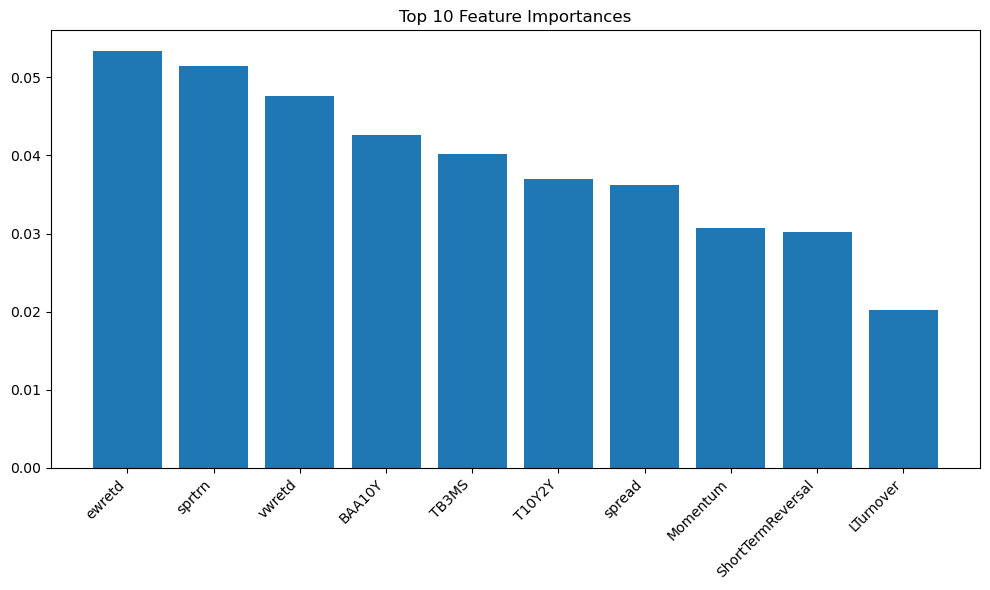

In [340]:
# 4. 特征重要性
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [142]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

In [143]:
# 特征选择
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))
X_selected = selector.fit_transform(X, y)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)

# 模型参数
rf_params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42
}

# 训练模型
rf_model = RandomForestRegressor(**rf_params)

# 使用时间序列交叉验证
r2_scores = []
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf_model.fit(X_train, y_train)
    r2_scores.append(rf_model.score(X_test, y_test))

print(f"Average R2 score: {np.mean(r2_scores)}")

Average R2 score: 0.13620603079027235


In [188]:
y_test.head()

,RET
date,
2023-01-31,0.009021
2023-02-28,-0.003448
2023-03-31,0.015644
2023-04-30,0.007541
2023-05-31,-0.000282


In [201]:
X_test.index

DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31',
               ...
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', name='date', length=319, freq=None)

## 超参数优化

In [288]:
from sklearn.model_selection import RandomizedSearchCV


In [296]:
y_train_array = y_train['RET']


In [291]:
y_train.shape

(2995, 1)

In [297]:
# 设置随机森林的超参数范围
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(5, 26)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 创建随机森林模型
rf = RandomForestRegressor(random_state=42)

# 使用 RandomizedSearchCV 进行超参数搜索
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# 拟合随机搜索模型
random_search.fit(X_train, y_train_array)

# 输出最佳参数和最佳模型
print("最佳参数：", random_search.best_params_)
best_model = random_search.best_estimator_

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"测试集的 MSE: {mse:.2f}")
print(f"测试集的 R2: {r2:.2f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the d

最佳参数： {'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 21, 'bootstrap': True}
测试集的 MSE: 0.00
测试集的 R2: -0.03
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   4.7s
[CV] END bootstrap=False, max_depth=23, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.6s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.3s
[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=700; total time= 1.9min
[CV] END bootstrap=True, max_depth=23, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=23, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootst

In [ ]:
{'n_estimators': 900, 'min_samples_split': 2, 'min_s amples_leaf': 4, 'max_features': 'auto', 'max_depth': 21, 'bootstrap': True}
测试集的 MSE: 0.00
测试集的 R2: -0.03

In [251]:
# 进行预测
y_pred = rf_model.predict(X_test)

# 假设rf_data是您的原始数据集
results = pd.DataFrame({
    'yhat': y_pred,
    'y_true': y_test['RET']
}, index=X_test.index)
results.index.name = 'date'

# 添加TICKER信息
results = results.merge(rf_data[['TICKER']], left_index=True, right_index=True, how='left')



In [262]:
# 重置索引，使用日期和TICKER作为多重索引
results_reset = results.reset_index()
results_reset = results_reset.set_index(['date', 'TICKER'])

# 分配权重
def allocate_weights(group):
    positive_preds = group[group['yhat'] > 0]
    if len(positive_preds) == 0:
        return pd.Series(0, index=group.index)
    weights = positive_preds['yhat'] / positive_preds['yhat'].sum()
    return weights

portfolio_weights = results_reset.groupby('date', group_keys=False).apply(allocate_weights)
portfolio_weights.name = 'weight'



In [263]:
portfolio_weights.to_csv('weights.csv')

In [264]:
# 合并权重和结果
merged_data = results_reset.join(portfolio_weights, how='left')

# 计算每日投资组合收益
portfolio_returns = (merged_data['weight'] * merged_data['y_true']).groupby('date').sum()

In [250]:
results.head()

,yhat,y_true
date,,
2023-01-31,0.008510,0.009021
2023-02-28,0.004104,-0.003448
2023-03-31,0.018785,0.015644
2023-04-30,0.004642,0.007541
2023-05-31,0.005226,-0.000282


In [286]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=12):
    excess_returns = returns - risk_free_rate/periods_per_year
    annual_return = returns.mean() * periods_per_year
    annual_volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(portfolio_returns)
print(f"投资组合夏普比率: {sharpe_ratio:.2f}")

投资组合夏普比率: 2.36


In [268]:
rf_data.columns

Index(['TICKER', 'RET', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm',
       'cfm', 'roa', 'roe', 'roce', 'efftax', 'ps', 'pcf', 'debt_ebitda',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa',
       'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap',
       'totdebt_invcap', 'capital_ratio', 'inv_turn', 'at_turn', 'rect_turn',
       'pay_turn', 'cash_conversion', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
       'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual',
       'ptb', 'PEG_trailing', 'divyield', 'vwretd', 'ewretd', 'sprtrn', 'Beta',
       'BetaSquared', 'Idi

In [270]:
# 假设 rf_data 包含 'date' 和 'risk_free_rate' 列
rf_rates = pd.DataFrame()
rf_rates['tbl'] = rf_data['TB3MS'].copy()


In [271]:
portfolio_data = portfolio_returns.to_frame().join(rf_rates)
portfolio_data.columns = ['portfolio_return', 'risk_free_rate']

In [285]:
def calculate_sharpe_ratio(returns, rf_rates, periods_per_year=12):
    excess_returns = returns['portfolio_return'] - returns['risk_free_rate']
    annual_return = excess_returns.mean() * periods_per_year
    annual_volatility = excess_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annual_return / annual_volatility
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(portfolio_data,portfolio_data['risk_free_rate'], periods_per_year=12)
print(f"投资组合夏普比率: {sharpe_ratio:.2f}")

投资组合夏普比率: -10.23


In [272]:
def rolling_sharpe_ratio(returns, window=12):
    excess_returns = returns['portfolio_return'] - returns['risk_free_rate']
    rolling_mean = excess_returns.rolling(window=window).mean() * 12
    rolling_std = excess_returns.rolling(window=window).std() * np.sqrt(12)
    return rolling_mean / rolling_std

portfolio_data['rolling_sharpe'] = rolling_sharpe_ratio(portfolio_data)

In [283]:
portfolio_data.dtypes

portfolio_return            float64
risk_free_rate              float64
rolling_sharpe              float64
cumulative_return           float64
cumulative_excess_return    float64
dtype: object

In [273]:
portfolio_data['cumulative_return'] = (1 + portfolio_data['portfolio_return']).cumprod() - 1
portfolio_data['cumulative_excess_return'] = (1 + (portfolio_data['portfolio_return'] - portfolio_data['risk_free_rate'])).cumprod() - 1

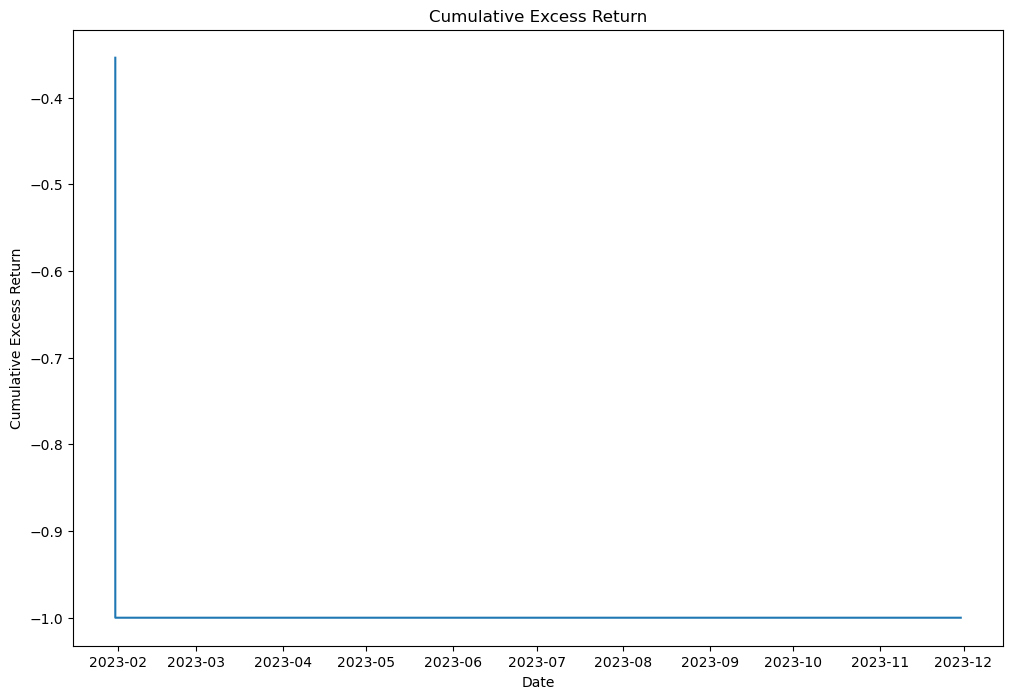

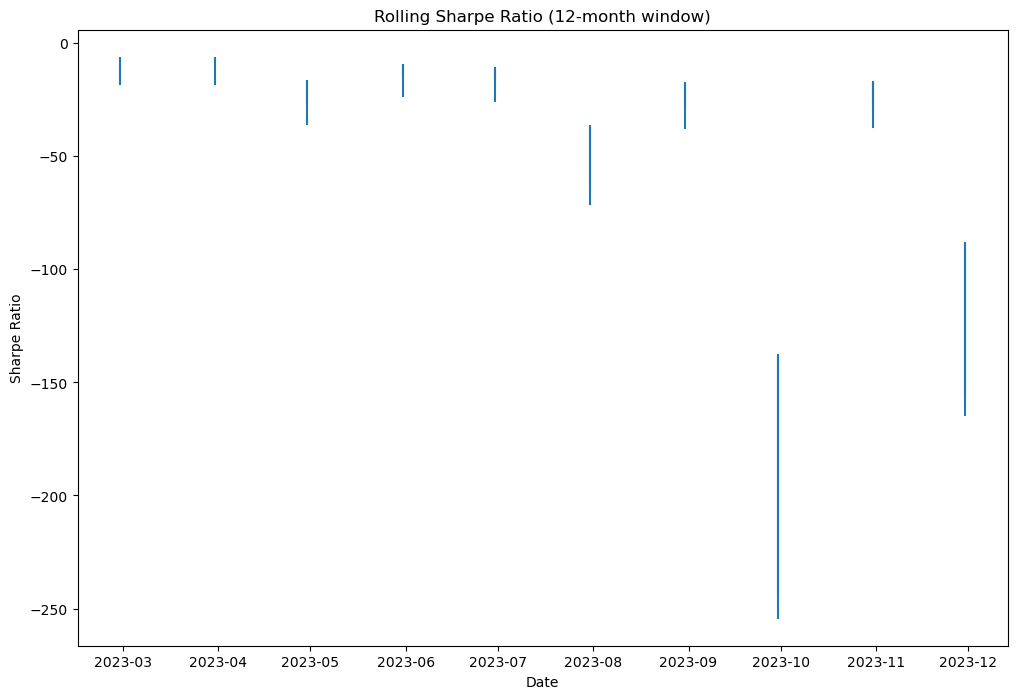

In [274]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(portfolio_data.index, portfolio_data['cumulative_excess_return'])
plt.title('Cumulative Excess Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Excess Return')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(portfolio_data.index, portfolio_data['rolling_sharpe'])
plt.title('Rolling Sharpe Ratio (12-month window)')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show()

In [151]:
# class TimeBasedCV:
#     def __init__(self, train_period, val_period, test_period, freq='M'):
#         self.train_period = train_period  # Number of periods for the training set
#         self.val_period = val_period      # Number of periods for the validation set
#         self.test_period = test_period    # Number of periods for the test set
#         self.freq = freq                  # Frequency of the periods

#     def split(self, data, first_split_date):
#         # Generate dates from the start date to the end date with the given frequency
#         end_date = data.index.max()
#         start_date = first_split_date - pd.DateOffset(months=self.train_period)

#         dates = pd.date_range(start=start_date, end=end_date, freq=self.freq)
        
#         # Loop through the dates ensuring no index out of bounds error
#         for i in range(len(dates) - self.train_period - self.val_period - self.test_period + 1):
#             train_start = dates[i]
#             train_end = dates[i + self.train_period]
#             val_start = train_end
#             val_end = train_end + pd.DateOffset(months=self.val_period)
#             test_start = val_end
#             test_end = val_end + pd.DateOffset(months=self.test_period)

#             if test_end > end_date:
#                 break  # Break the loop if the calculated test end date exceeds the data range

#             train_mask = (data.index >= train_start) & (data.index < train_end)
#             val_mask = (data.index >= val_start) & (data.index < val_end)
#             test_mask = (data.index >= test_start) & (data.index < test_end)

#             yield data.index[train_mask], data.index[val_mask], data.index[test_mask]


In [155]:
# print("Data date range:", X.index.min(), "to", X.index.max())


Data date range: 2014-02-28 00:00:00 to 2023-11-30 00:00:00


In [162]:
# from sklearn.model_selection import ParameterGrid
# # Initialize TimeBasedCV with the scheme you want to use
# tscv = TimeBasedCV(train_period=60, val_period=24, test_period=24, freq='M')  # 'M' for monthly frequency

# # Containers for results
# predictions = []
# y_test_list = []
# dates = []
# dic_r2_all = {}
# dic_max_depth_all = {}

# # Hyperparameters grid
# param_grid = {
#     'max_depth': [1,2,3,4,5,6],
#     'max_features': [3, 6, 12, 24, 46, 49]
# }
# grid = list(ParameterGrid(param_grid))
# mse = np.full((len(grid),1), np.nan, dtype=float)

# # Perform rolling window cross-validation
# for train_index, val_index, test_index in tscv.split(X, first_split_date=pd.Timestamp('2020-01-31')):
#     if len(train_index) == 0 or len(val_index) == 0 or len(test_index) == 0:
#         print("Empty split found. Check date alignment and range coverage.")
#         continue  # Skip this iteration if any split is empty
#     X_train = X.iloc[train_index]
#     y_train = y.iloc[train_index]
#     X_val = X.iloc[val_index]
#     y_val = y.iloc[val_index]
#     X_test = X.iloc[test_index]
#     y_test = y.iloc[test_index]

#     # Iterate over each combination of hyperparameters
#     for i in range(len(grid)):
#         rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
#                                          max_depth=grid[i]["max_depth"],
#                                          max_features=grid[i]["max_features"])
#         rf_model.fit(X_train, y_train)
#         y_val_pred = rf_model.predict(X_val)
#         mse[i, 0] = mean_squared_error(y_val, y_val_pred)

#     # Optimal hyperparameters
#     optim_param = grid[np.argmin(mse)]
#     rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
#                                      max_depth=optim_param["max_depth"],
#                                      max_features=optim_param["max_features"])
#     rf_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
#     preds = rf_model.predict(X_test)

#     # Store results
#     predictions.append(preds)
#     dates.append(y_test.index)
#     y_test_list.append(y_test)

#     # Calculate and store R^2 and model depth
#     r2 = 1 - sum((y_test - preds) ** 2) / sum((y_test - np.mean(y_test)) ** 2)
#     dic_r2_all["r2." + str(y_test.index[0])] = r2
#     dic_max_depth_all["depth." + str(y_test.index[0])] = optim_param["max_depth"]

# # Aggregate results for overall performance
# predictions_all = np.concatenate(predictions)
# y_test_list_all = np.concatenate(y_test_list)
# dates_all = np.concatenate(dates)

# R2OOS_RF = 1 - sum((y_test_list_all - predictions_all) ** 2) / sum((y_test_list_all - np.mean(y_test_list_all)) ** 2)
# print("R2OOS random forest: ", R2OOS_RF)

ValueError: need at least one array to concatenate

## 3.5 Portfolio Optimization

In [163]:
#Generate a results dataframe containing the model predictions (yhat) and the true values (y_true) 
#of the dependent variable for each stock in each month

yhat = y_prep.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[36:51]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results

NameError: name 'predictions_all' is not defined

## 4. Assessment 